# Spatial Combinational Complexes for Hyperlocal Air Quality Downscaling

This notebook presents the required steps to reproduce the geospatial combinational complex benchmark dataset used in the $E(n)$-equivariant topological neural networks.

Unfortunatelly, some of the steps require downloading large files manually, which are subject to changes in the API of their corresponding sources. We include the steps here which are functional as of June 14, 2024.

## 1. Prerequisites

### Dependencies

In [2]:
# tested on python 3.10
%pip install -q \
    geopandas \
    matplotlib \
    pygris \
    tqdm \
    osmnx \
    contextily \
    ipykernel \
    IProgress \
    pyarrow \
    scikit-learn    

Note: you may need to restart the kernel to use updated packages.


Load libraries

In [25]:
import geopandas as gpd
import pandas as pd
import pygris
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import matplotlib
from tqdm.notebook import tqdm
import osmnx as ox
import contextily as cx
import json
from sklearn.neighbors import NearestNeighbors
import os

plt.rcParams["figure.figsize"] = [8, 8]
matplotlib.rcParams['figure.dpi'] = 300

In [4]:
# Supress warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

### Manual Downloads

There are two data sources that require manual downloading. These sources are the AADT (Annual Average Daily Traffic) from the NY State Department of Transportation and the PLUTO (Primary Land Use Tax Lot Output) dataset from the NYC Department of City Planning.

#### Annual Average Daily Traffic (AADT)

Go the NY State DOT website with the AADT data:
[https://nysdottrafficdata.drakewell.com/publicmultinodemap.asp](https://nysdottrafficdata.drakewell.com/publicmultinodemap.asp)

Under the right navigation menu, panel `Annual Statistics`, select the option `All Station AADT and Truck Percent`, and download as `Shapefile`. After downloading the file, it must be uncompress in the `data` directory. This is how the uncompress file should look like:

```folder
data/
  aadt_and_truckpct/
    features.shp
    features.shx
    features.dbf
    features.prj
  ...
```

#### Primary Land Use Tax Lot Output (PLUTO)

Go to the NYC Department of City Planning website with the PLUTO data at:
[https://www.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page]

Select the file `PLUTO (.csv format)` and download it to the `data` directory.

```folder
data/
  nyc_pluto_24v1_1_csv/
    pluto_24v1_1
    pluto_readme.pdf
    pluto_datadictionary.pdf
  ...
```

## 2. Geometry Processing

#### Automatic PM 2.5 data download from MIT-Seansable City

In [5]:
urls = [
    f"https://raw.githubusercontent.com/MIT-Senseable-City-Lab/OSCS/main/Explore/Datasets/NYC_Pilot2_PM_Part{i}.csv"
    for i in [1, 2, 3]
]

info = {
    "target": "pm25",
    "lat": "latitude",
    "lon": "longitude",
    "time": "time",
    "time_input_format": "unix",
    "time_zone": "US/Eastern",
    "features": ["temperature", "humidity"],
    "ids": ["SensorID"],
}

# download the three datasets
pts = []
for url in urls:
    chunk = pd.read_csv(url)
    pts.append(chunk)
pts = pd.concat(pts, ignore_index=True)

# convert the time column to local time
pts["time"] = pd.to_datetime(pts[info["time"]], unit="s")
pts["time"] = pts["time"].dt.tz_localize("UTC").dt.tz_convert(info["time_zone"])

# filter columns
cols = (
    info["ids"]
    + [info["time"], info["lon"], info["lat"], info["target"]]
    + info["features"]
)
pts = pts[cols]

# rename lon/lat columns
pts = pts.rename(columns={info["lon"]: "lon", info["lat"]: "lat"})
pts["time_of_day"] = pts.time.dt.hour + pts.time.dt.minute / 60
pts["weekday"] = pts.time.dt.weekday

# keep measurements during weekdays and 9am to 5pm
pts = pts[(pts.weekday < 5) & (pts.time_of_day >= 9) & (pts.time_of_day <= 17)]

# print date range
print(pts.time.min(), pts.time.max())

# original shape
print(pts.shape)

2021-09-10 09:00:00-04:00 2021-12-15 09:35:55-05:00
(242282, 9)


Coarsen points / keep polygons that contain points

In [6]:
delta_s = 0.0002  # 0.0001 deg ~ 20m
pts["lon"] = delta_s * np.round(pts.lon / delta_s)
pts["lat"] = delta_s * np.round(pts.lat / delta_s)

# keep only time of day not date and weekday
group_cols = ["lon", "lat"]
pts = (
    pts.groupby(group_cols)
    .agg(
        pm25=pd.NamedAgg(column="pm25", aggfunc=np.median),
        time_of_day=pd.NamedAgg(column="time_of_day", aggfunc=np.median),
    )
    .reset_index()
)

print(f"Shape after grouping: {pts.shape}")

Shape after grouping: (12741, 4)


#### Get geometries for the  combinatiorial complex objects.

Each rank corresponds to a type of geospatial (GIS) object:

1. **(Rank 0)**: Points
2. **(Rank 1)**: Polylines
3. **(Rank 2)**: Polygons

In [7]:
# projection useful throughout
wgs84 = "EPSG:4326"  # unit is degrees
mercator = "EPSG:3857"  # unit is meters, useful for meter computations

#  ==== RANK 0: POINTS ====
geom = gpd.points_from_xy(pts.lon, pts.lat, crs=wgs84)
pts = gpd.GeoDataFrame(pts, geometry=geom)

# ==== RANK 1: ROADS =====
roads = pygris.roads(state="NY", county="Bronx").to_crs(wgs84)

# ==== RANK 2: TRACTS ====
tracts = pygris.tracts(
    state="NY", county="Bronx", year=2020, cache=True, cb=True
).to_crs(wgs84)
tracts["TRACTCE"] = tracts["TRACTCE"].astype(int)
tracts.set_index("TRACTCE", inplace=True)

Using the default year of 2021
Using FIPS code '36' for input 'NY'
Using FIPS code '005' for input 'Bronx'
Using FIPS code '36' for input 'NY'
Using FIPS code '005' for input 'Bronx'


Keep only valid points/roads/tracts that interesect (ensures valid combinatorial complex).

In [8]:
# add a 5m buffer around roads to obtain intersections with other geometries
geom = roads.geometry.to_crs(mercator).buffer(5).to_crs(wgs84)
road_buff = gpd.GeoDataFrame(geometry=geom)
sjoin1 = gpd.sjoin(pts, road_buff, predicate="within", how="inner")
valid_pts1 = sjoin1.index.unique()

# similarly, add a 5m buffer around tracts
geom = tracts.geometry.to_crs(mercator).buffer(5).to_crs(wgs84)
tract_buff = gpd.GeoDataFrame(geometry=geom)
sjoin2 = gpd.sjoin(pts, tract_buff, predicate="within", how="inner")
valid_pts2 = sjoin2.index.unique()

# keep only points that are valid in both cases
valid_pts = list(set(valid_pts1) & set(valid_pts2))

# take subset of valid points, roads, and tracts
pts = pts.loc[valid_pts]
sjoin1 = sjoin1.loc[sjoin1.index.isin(valid_pts)]
sjoin2 = sjoin2.loc[sjoin2.index.isin(valid_pts)]
valid_roads = sjoin1.index_right.unique()
valid_tracts = sjoin2.index_right.unique()
sjoin1 = sjoin1.loc[sjoin1.index_right.isin(valid_roads)]
sjoin2 = sjoin2.loc[sjoin2.index_right.isin(valid_tracts)]
roads = roads.loc[valid_roads]
roads_buff = road_buff.loc[valid_roads]
tracts = tracts.loc[valid_tracts]
tract_buff = tract_buff.loc[valid_tracts]

# obtain a map from index to ordering
ixmap_pts = {k: i for i, k in enumerate(pts.index)}
ixmap_roads = {k: i for i, k in enumerate(roads.index)}
ixmap_tracts = {k: i for i, k in enumerate(tracts.index)}

print("Final set of points")
display(pts)

print("Final set of roads")
display(roads)

print("Final set of tracts")
display(tracts)

Final set of points


lon      lat       pm25  time_of_day                    geometry
8199 -73.8882  40.8266   3.288390    11.183333  POINT (-73.88820 40.82660)
8201 -73.8882  40.8288   4.348238    13.200000  POINT (-73.88820 40.82880)
8207 -73.8882  40.8330  10.109027    14.033333  POINT (-73.88820 40.83300)
8214 -73.8882  40.8366   4.366279    14.966667  POINT (-73.88820 40.83660)
8218 -73.8882  40.8398   3.763369    14.766667  POINT (-73.88820 40.83980)
...       ...      ...        ...          ...                         ...
8183 -73.8882  40.8178   3.087006     9.716667  POINT (-73.88820 40.81780)
8186 -73.8882  40.8204   5.729451    12.183333  POINT (-73.88820 40.82040)
8187 -73.8882  40.8206   5.471461    10.750000  POINT (-73.88820 40.82060)
8189 -73.8882  40.8214  10.635258    15.650000  POINT (-73.88820 40.82140)
8191 -73.8882  40.8218   3.801054    12.433333  POINT (-73.88820 40.82180)

[3939 rows x 5 columns]

Final set of roads


LINEARID           FULLNAME RTTYP  MTFCC  \
1705   1105089436395               None  None  S1630   
1073   1104492919899    Pedestrian Opas     M  S1710   
1666   1106087439044  Major Deegan Expy     M  S1100   
2360   1104701100699              I- 87     I  S1100   
592   11015503292274              I- 87     I  S1100   
...              ...                ...   ...    ...   
984    1104699162063             I- 695     I  S1100   
1995   1108475888251   Throgs Neck Expy     M  S1100   
999     110391527854        Pinkney Ave     M  S1400   
2744    110391529433     Hutchinson Ave     M  S1400   
1697    110391526531        Hollers Ave     M  S1400   

                                               geometry  
1705  LINESTRING (-73.93258 40.82553, -73.93258 40.8...  
1073  LINESTRING (-73.93151 40.83084, -73.93194 40.8...  
1666  LINESTRING (-73.87801 40.90597, -73.87811 40.9...  
2360  LINESTRING (-73.91148 40.80494, -73.91233 40.8...  
592   LINESTRING (-73.87819 40.90598, -73.87829 40.9...  
...                                                 ...  
984   LINESTRING (-73.81151 40.81946, -73.81287 40.8...  
1995  LINESTRING (-73.82525 40.83694, -73.82461 40.8...  
999   LINESTRING (-73.82354 40.88565, -73.82417 40.8...  
2744  LINESTRING (-73.82259 40.88594, -73.82278 40.8...  
1697  LINESTRING (-73.83057 40.88336, -73.82964 40.8...  

[550 rows x 5 columns]

Final set of tracts


STATEFP COUNTYFP              AFFGEOID        GEOID    NAME  \
TRACTCE                                                               
6301         36      005  1400000US36005006301  36005006301   63.01   
18900        36      005  1400000US36005018900  36005018900     189   
5100         36      005  1400000US36005005100  36005005100      51   
19300        36      005  1400000US36005019300  36005019300     193   
1901         36      005  1400000US36005001901  36005001901   19.01   
...         ...      ...                   ...          ...     ...   
30201        36      005  1400000US36005030201  36005030201  302.01   
48401        36      005  1400000US36005048401  36005048401  484.01   
27600        36      005  1400000US36005027600  36005027600     276   
27401        36      005  1400000US36005027401  36005027401  274.01   
46209        36      005  1400000US36005046209  36005046209  462.09   

                    NAMELSAD STUSPS    NAMELSADCO STATE_NAME LSAD    ALAND  \
TRACTCE                                                                      
6301      Census Tract 63.01     NY  Bronx County   New York   CT   782166   
18900       Census Tract 189     NY  Bronx County   New York   CT   355570   
5100         Census Tract 51     NY  Bronx County   New York   CT   510445   
19300       Census Tract 193     NY  Bronx County   New York   CT   241287   
1901      Census Tract 19.01     NY  Bronx County   New York   CT   205007   
...                      ...    ...           ...        ...  ...      ...   
30201    Census Tract 302.01     NY  Bronx County   New York   CT   221595   
48401    Census Tract 484.01     NY  Bronx County   New York   CT   504791   
27600       Census Tract 276     NY  Bronx County   New York   CT  1837997   
27401    Census Tract 274.01     NY  Bronx County   New York   CT   701116   
46209    Census Tract 462.09     NY  Bronx County   New York   CT   462184   

         AWATER                                           geometry  
TRACTCE                                                             
6301       9963  POLYGON ((-73.93306 40.82816, -73.93146 40.828...  
18900         0  POLYGON ((-73.93314 40.83481, -73.93036 40.834...  
5100          0  POLYGON ((-73.93260 40.81152, -73.93240 40.814...  
19300         0  POLYGON ((-73.93301 40.83568, -73.93061 40.839...  
1901          0  POLYGON ((-73.93094 40.80825, -73.92933 40.809...  
...         ...                                                ...  
30201         0  POLYGON ((-73.82826 40.86085, -73.82642 40.863...  
48401         0  POLYGON ((-73.84044 40.88473, -73.83773 40.885...  
27600    499778  POLYGON ((-73.83282 40.85612, -73.83199 40.856...  
27401         0  POLYGON ((-73.82624 40.84299, -73.82581 40.842...  
46209     14970  POLYGON ((-73.83874 40.88127, -73.83664 40.882...  

[151 rows x 13 columns]

### Cell membership indicators

Recall that from the point of view of combinatorial complexes (CCs), a cell is described entirely by the atoms it contains. Thus we much specify the rank 1 cells (roads) and the rank 2 cells (tracts) by which points they contain.

In [9]:
# rank 0 cells are trivial singletons
cell_0 = [[i] for i in range(len(pts))]

# leverage that sjoin1 and sjoin2 already contain the necessary information
# of which points are in which road/tract
cell_1 = [[] for _ in range(len(roads))]
cell_2 = [[] for _ in range(len(tracts))]

for ix, row in sjoin1.iterrows():
    src = ixmap_pts[ix]
    dst = ixmap_roads[row["index_right"]]
    cell_1[dst].append(src)

for ix, row in sjoin2.iterrows():
    src = ixmap_pts[ix]
    dst = ixmap_tracts[row["index_right"]]
    cell_2[dst].append(src)

As an extra computation that will be useful later, obtain the inverse mapping. That is, for each point, to which roads/tracts it belongs. In almost all cases a point only belong to onre road and one tract (exceptions only at the edges, and mostly due to the buffer).

In [10]:
map_0_1 = [[] for _ in range(len(pts))]
map_0_2 = [[] for _ in range(len(pts))]

for ix, row in sjoin1.iterrows():
    src = ixmap_pts[ix]
    dst = ixmap_roads[row["index_right"]]
    map_0_1[src].append(dst)

for ix, row in sjoin2.iterrows():
    src = ixmap_pts[ix]
    dst = ixmap_tracts[row["index_right"]]
    map_0_2[src].append(dst)

pts["road"] = map_0_1
pts["tract"] = map_0_2

### Create indicidences (upper/lower adjacencies) by the common neighbors rule

In [11]:
# === Incidences Rank 0 -> Rank 1 (used also as incidence(0, 1)) ====
edges_pts_road = set()
for i in range(len(pts)):
    for j, c in enumerate(cell_1):
        if i in c:
            edges_pts_road.add((i, j))
edges_pts_road = list(edges_pts_road)
print("Number of edges pts -> road", len(edges_pts_road))

# === Incidences Rank 1 -> Rank 2 ====
# strategy: create neighbors if they road and tract share a point
edges_road_tract = set()
for i, road in enumerate(cell_1):
    for k, tract in enumerate(cell_2):
        if set(road) & set(tract):
            edges_road_tract.add((i, k))
edges_road_tract = list(edges_road_tract)
print("Number of edges road -> tract", len(edges_road_tract))

Number of edges pts -> road 4938
Number of edges road -> tract 1332


### Visualize the resulting adjacencies

/var/folders/h3/2f91vbwj7r506n1w06610njh0000gn/T/ipykernel_85273/1078596856.py:26: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  tract_feats_k.plot(
/var/folders/h3/2f91vbwj7r506n1w06610njh0000gn/T/ipykernel_85273/1078596856.py:34: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  tract_feats_k.plot(


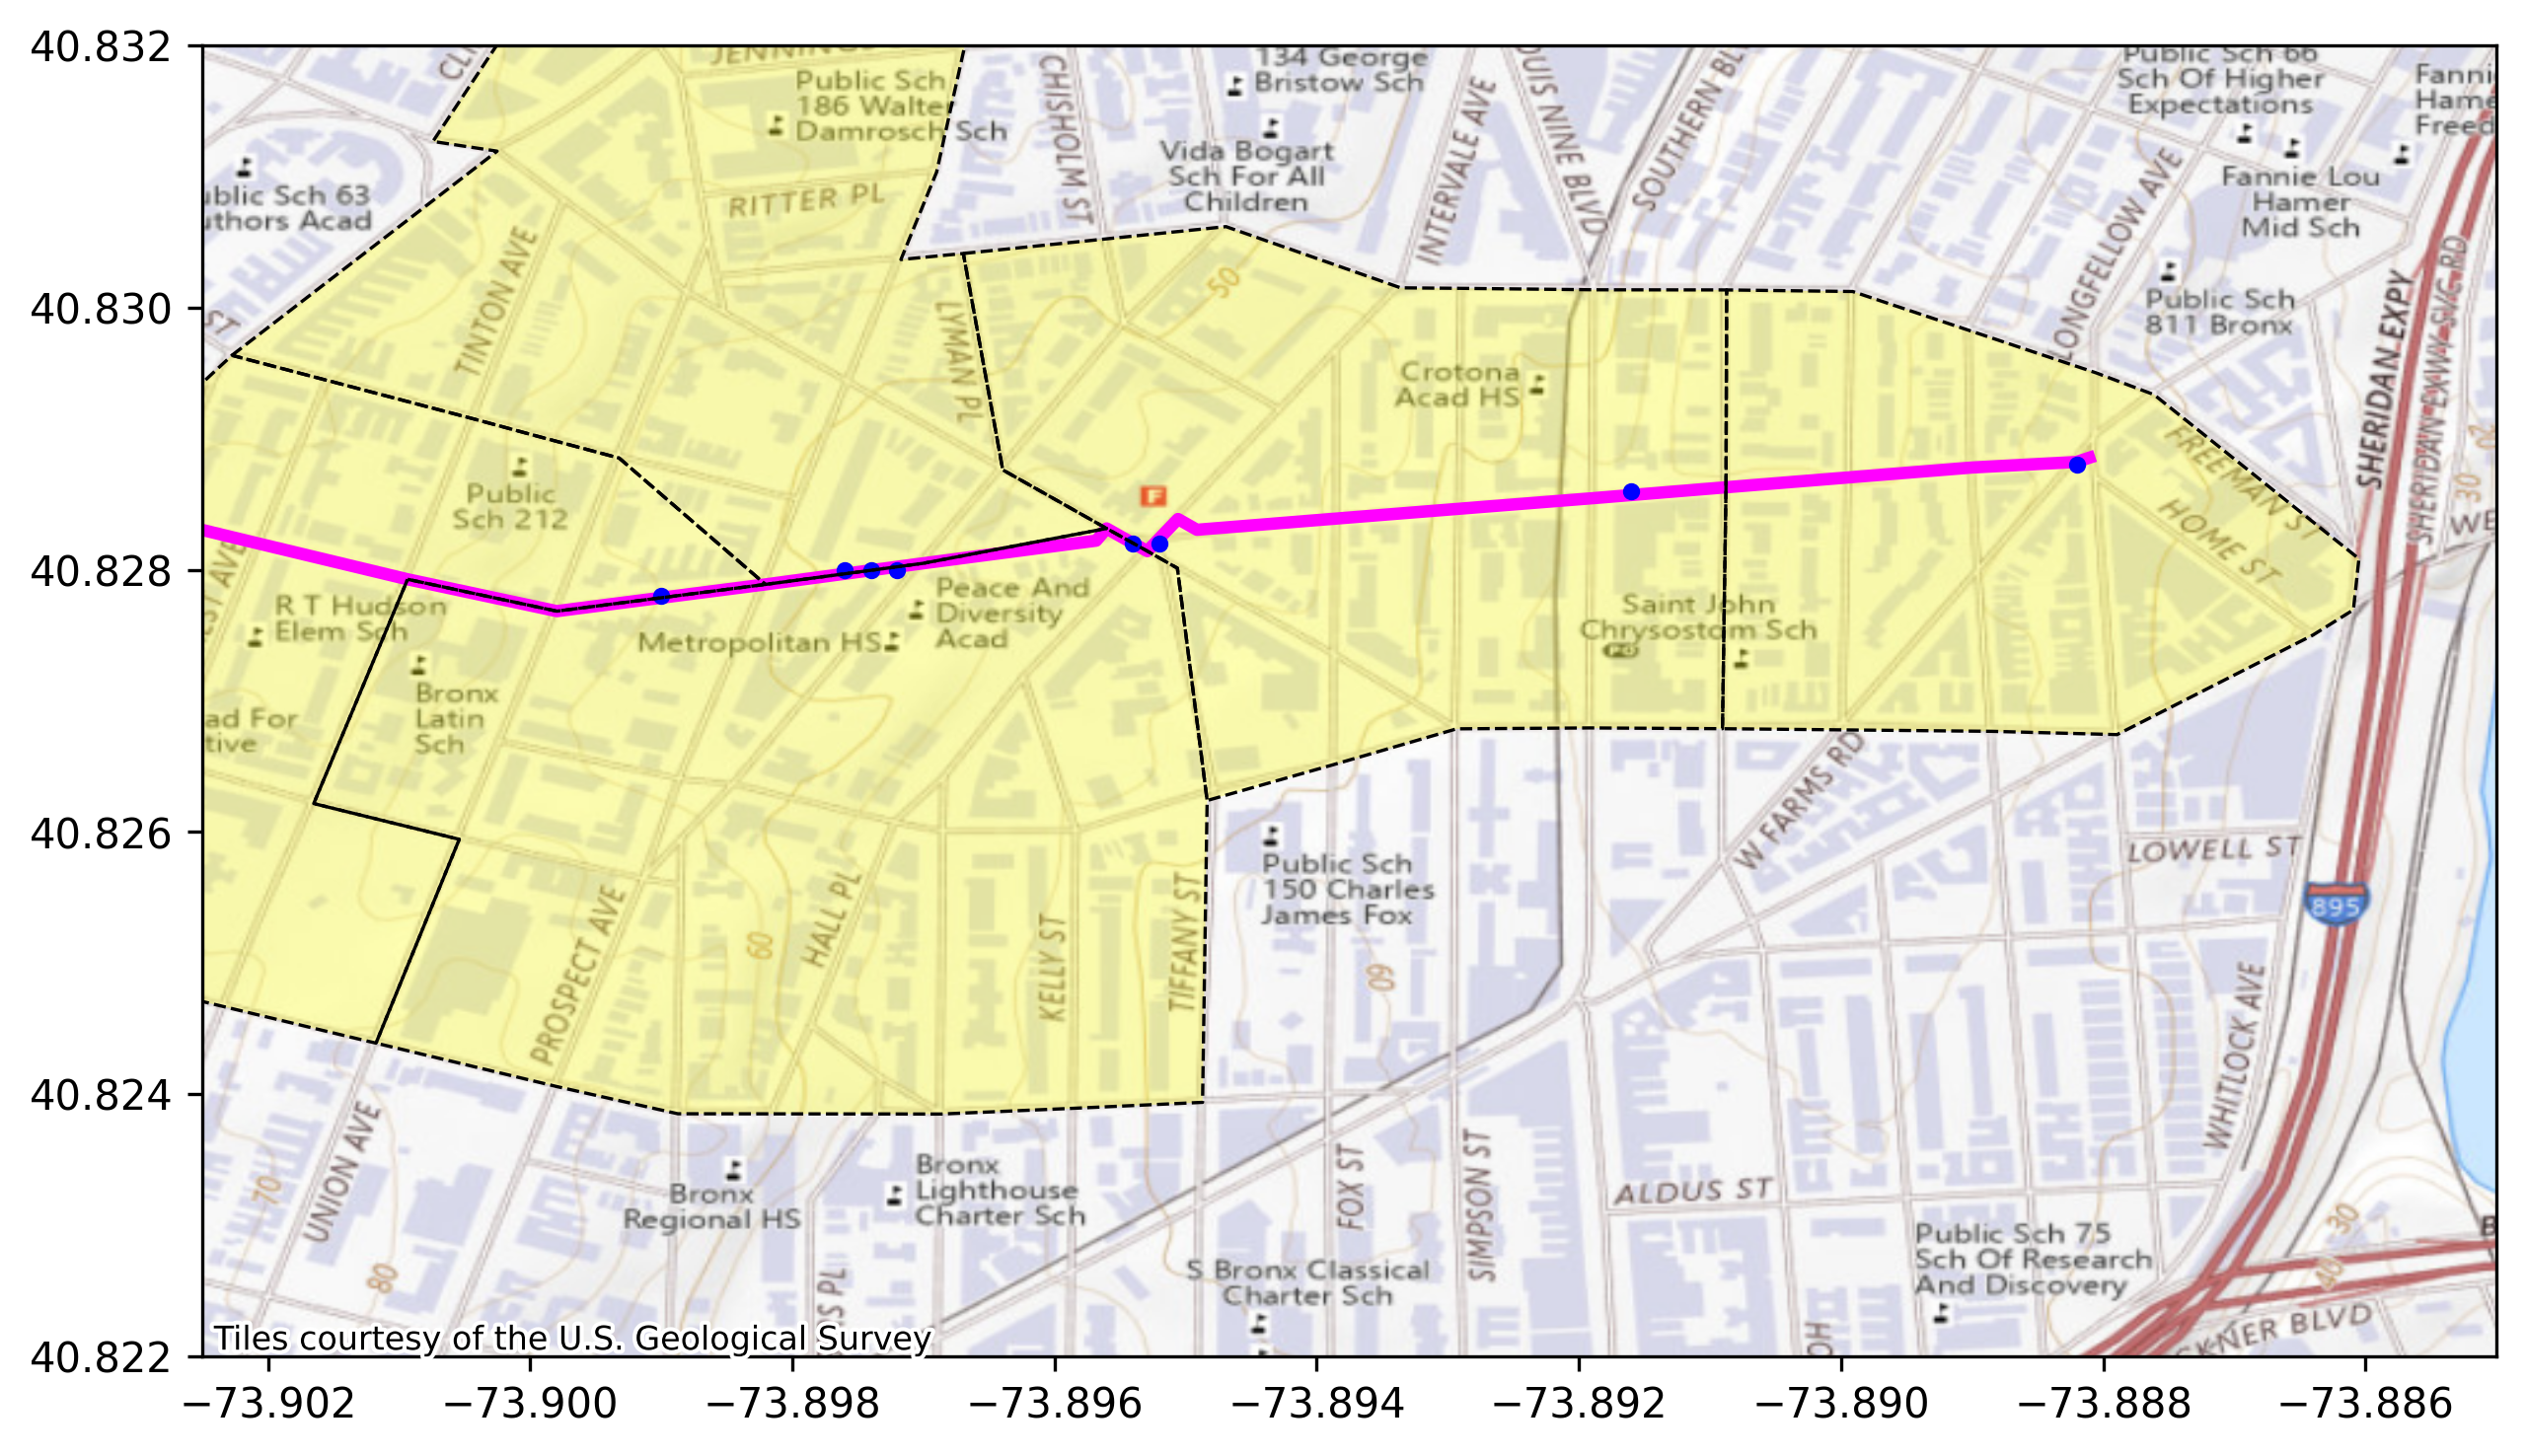

<Axes: >

In [12]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# iterate until we find the road that is closest the tgt point
tgt_point = np.array([40.828, -73.896])
closest_road = None
closest_dist = np.inf
for i, (index, row) in enumerate(roads.iterrows()):
    dist = row.geometry.distance(gpd.points_from_xy([tgt_point[1]], [tgt_point[0]])[0])
    if dist < closest_dist:
        closest_dist = dist
        closest_road = i

# Obtain the points, roads, and tracts to be displayed in the Figure, and their features
tgt_pts = [e[0] for e in edges_pts_road if e[1] == closest_road]
pts_k = pts.iloc[tgt_pts]

tgt_roads = [closest_road]
road_feats_k = roads.iloc[tgt_roads]

tgt_tracts = [e[1] for e in edges_road_tract if e[0] == closest_road]
tract_feats_k = tracts.iloc[tgt_tracts]


# roads.plot(ax=ax, color="black", alpha=0.1)
# make fill collor always yello
tract_feats_k.plot(
    "id",
    alpha=0.3,
    lw=0.0,
    ls="--",
    color="yellow",
    ax=ax,
)
tract_feats_k.plot(
    "id",
    edgecolor="black",
    ls="--",
    alpha=1.0,
    lw=0.8,
    color="none",
    ax=ax,
    zorder=11
)
road_feats_k.plot(color="magenta", linewidth=3, ax=ax)
# ensure pts appear on top of other plots
pts_k.plot(markersize=10, ax=ax, c="blue", zorder=10)

# plt.title("Example of road intersecting tracts")

# make sure that the axis coordinates do not use scientific notation
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)
plt.xlim(-73.9025, -73.885)
plt.ylim(40.822, 40.832)
cx.add_basemap(ax, crs=tracts.crs, zoom=16, source=cx.providers.USGS.USTopo)
plt.show()

# save as png
fig.savefig("notebooks/figs/spatial-cc-example.png", bbox_inches="tight")
ax

## 3. Feature Engineering

### Points (rank 0)

The points contain the labels (PM 2.5 at high resolution) and are complemented with predictions from open street map such as restaurants, schools, and traffic intersections with a radius.

In [13]:
# === Fetch OpenStreetMap data ===

# Step 1: Define your area of interest
place_name = "Bronx, New York, USA"

# Step 2: Download list of restaurants and schools
tags = {"amenity": ["restaurant", "school"]}
amenities = ox.geometries_from_place(place_name, tags)
ox_net = ox.graph_from_place(place_name, network_type="all")
# Convert the graph to a GeoDataFrame
ox_net_nodes, ox_net_edges = ox.graph_to_gdfs(ox_net)

ox_net_edges = ox_net_edges.to_crs(mercator)
ox_net_nodes = ox_net_nodes.to_crs(mercator)

# Step 3: Separate restaurants and schools into different GeoDataFrames
restaurants = amenities[amenities["amenity"] == "restaurant"].loc['node']
schools = amenities[amenities["amenity"] == "school"].loc['node']

In [14]:
## === Featurize by computing densities ===

# Make bufferes point data
buffer_distance1 = 300  # Buffer distance in meters
buffer_distance2 = 100  # Buffer distance in meters
buffered_pts_geom1 = pts.to_crs(mercator).buffer(buffer_distance1)
buffered_pts_geom2 = pts.to_crs(mercator).buffer(buffer_distance2)
buffered_pts = pts.to_crs(mercator).copy()
buffered_pts["buffer1"] = buffered_pts_geom1
buffered_pts["buffer2"] = buffered_pts_geom2

# Reproject to a projected coordinate system for accurate area calculations
restaurants = restaurants.to_crs(mercator)
schools = schools.to_crs(mercator)

C1 = buffer_distance1**2 * np.pi
C2 = buffer_distance2**2 * np.pi

# Calculate the proximity to the nearest school
def calculate_nearest_school_distance(point):
    distances = schools.geometry.distance(point) / 1e3  # in kilometers
    return distances.min()

# Function to calculate road and intersection density within a buffer
def calculate_densities(buffer, edges=ox_net_edges, nodes=ox_net_nodes):
    # Clip edges and nodes to the buffer
    clipped_edges = edges[edges.intersects(buffer)]
    clipped_nodes = nodes[nodes.intersects(buffer)]

    # Calculate road length and area
    road_length_km = clipped_edges["length"].sum() / 1e3  # in kilometers

    # Calculate intersection count
    intersection_count = len(clipped_nodes)

    # Calculate densities
    road_density = road_length_km / C2
    intersection_density = intersection_count / C2

    return road_density, intersection_density

restaurant_density = []
school_distance = []
road_density = []
intersection_density = []
for ix, row in tqdm(buffered_pts.iterrows(), total=len(buffered_pts)):
    restaurant_density.append(1000 * restaurants.intersects(row.buffer1).sum() / C1)
    school_distance.append(calculate_nearest_school_distance(row.geometry))
    rd, id = calculate_densities(row.buffer2)
    road_density.append(rd)
    intersection_density.append(id)

pts["restaurant_density"] = restaurant_density
pts["nearest_school_distance"] = school_distance
pts["road_density"] = road_density
pts["intersection_density"] = intersection_density

  0%|          | 0/3939 [00:00<?, ?it/s]

Visualize

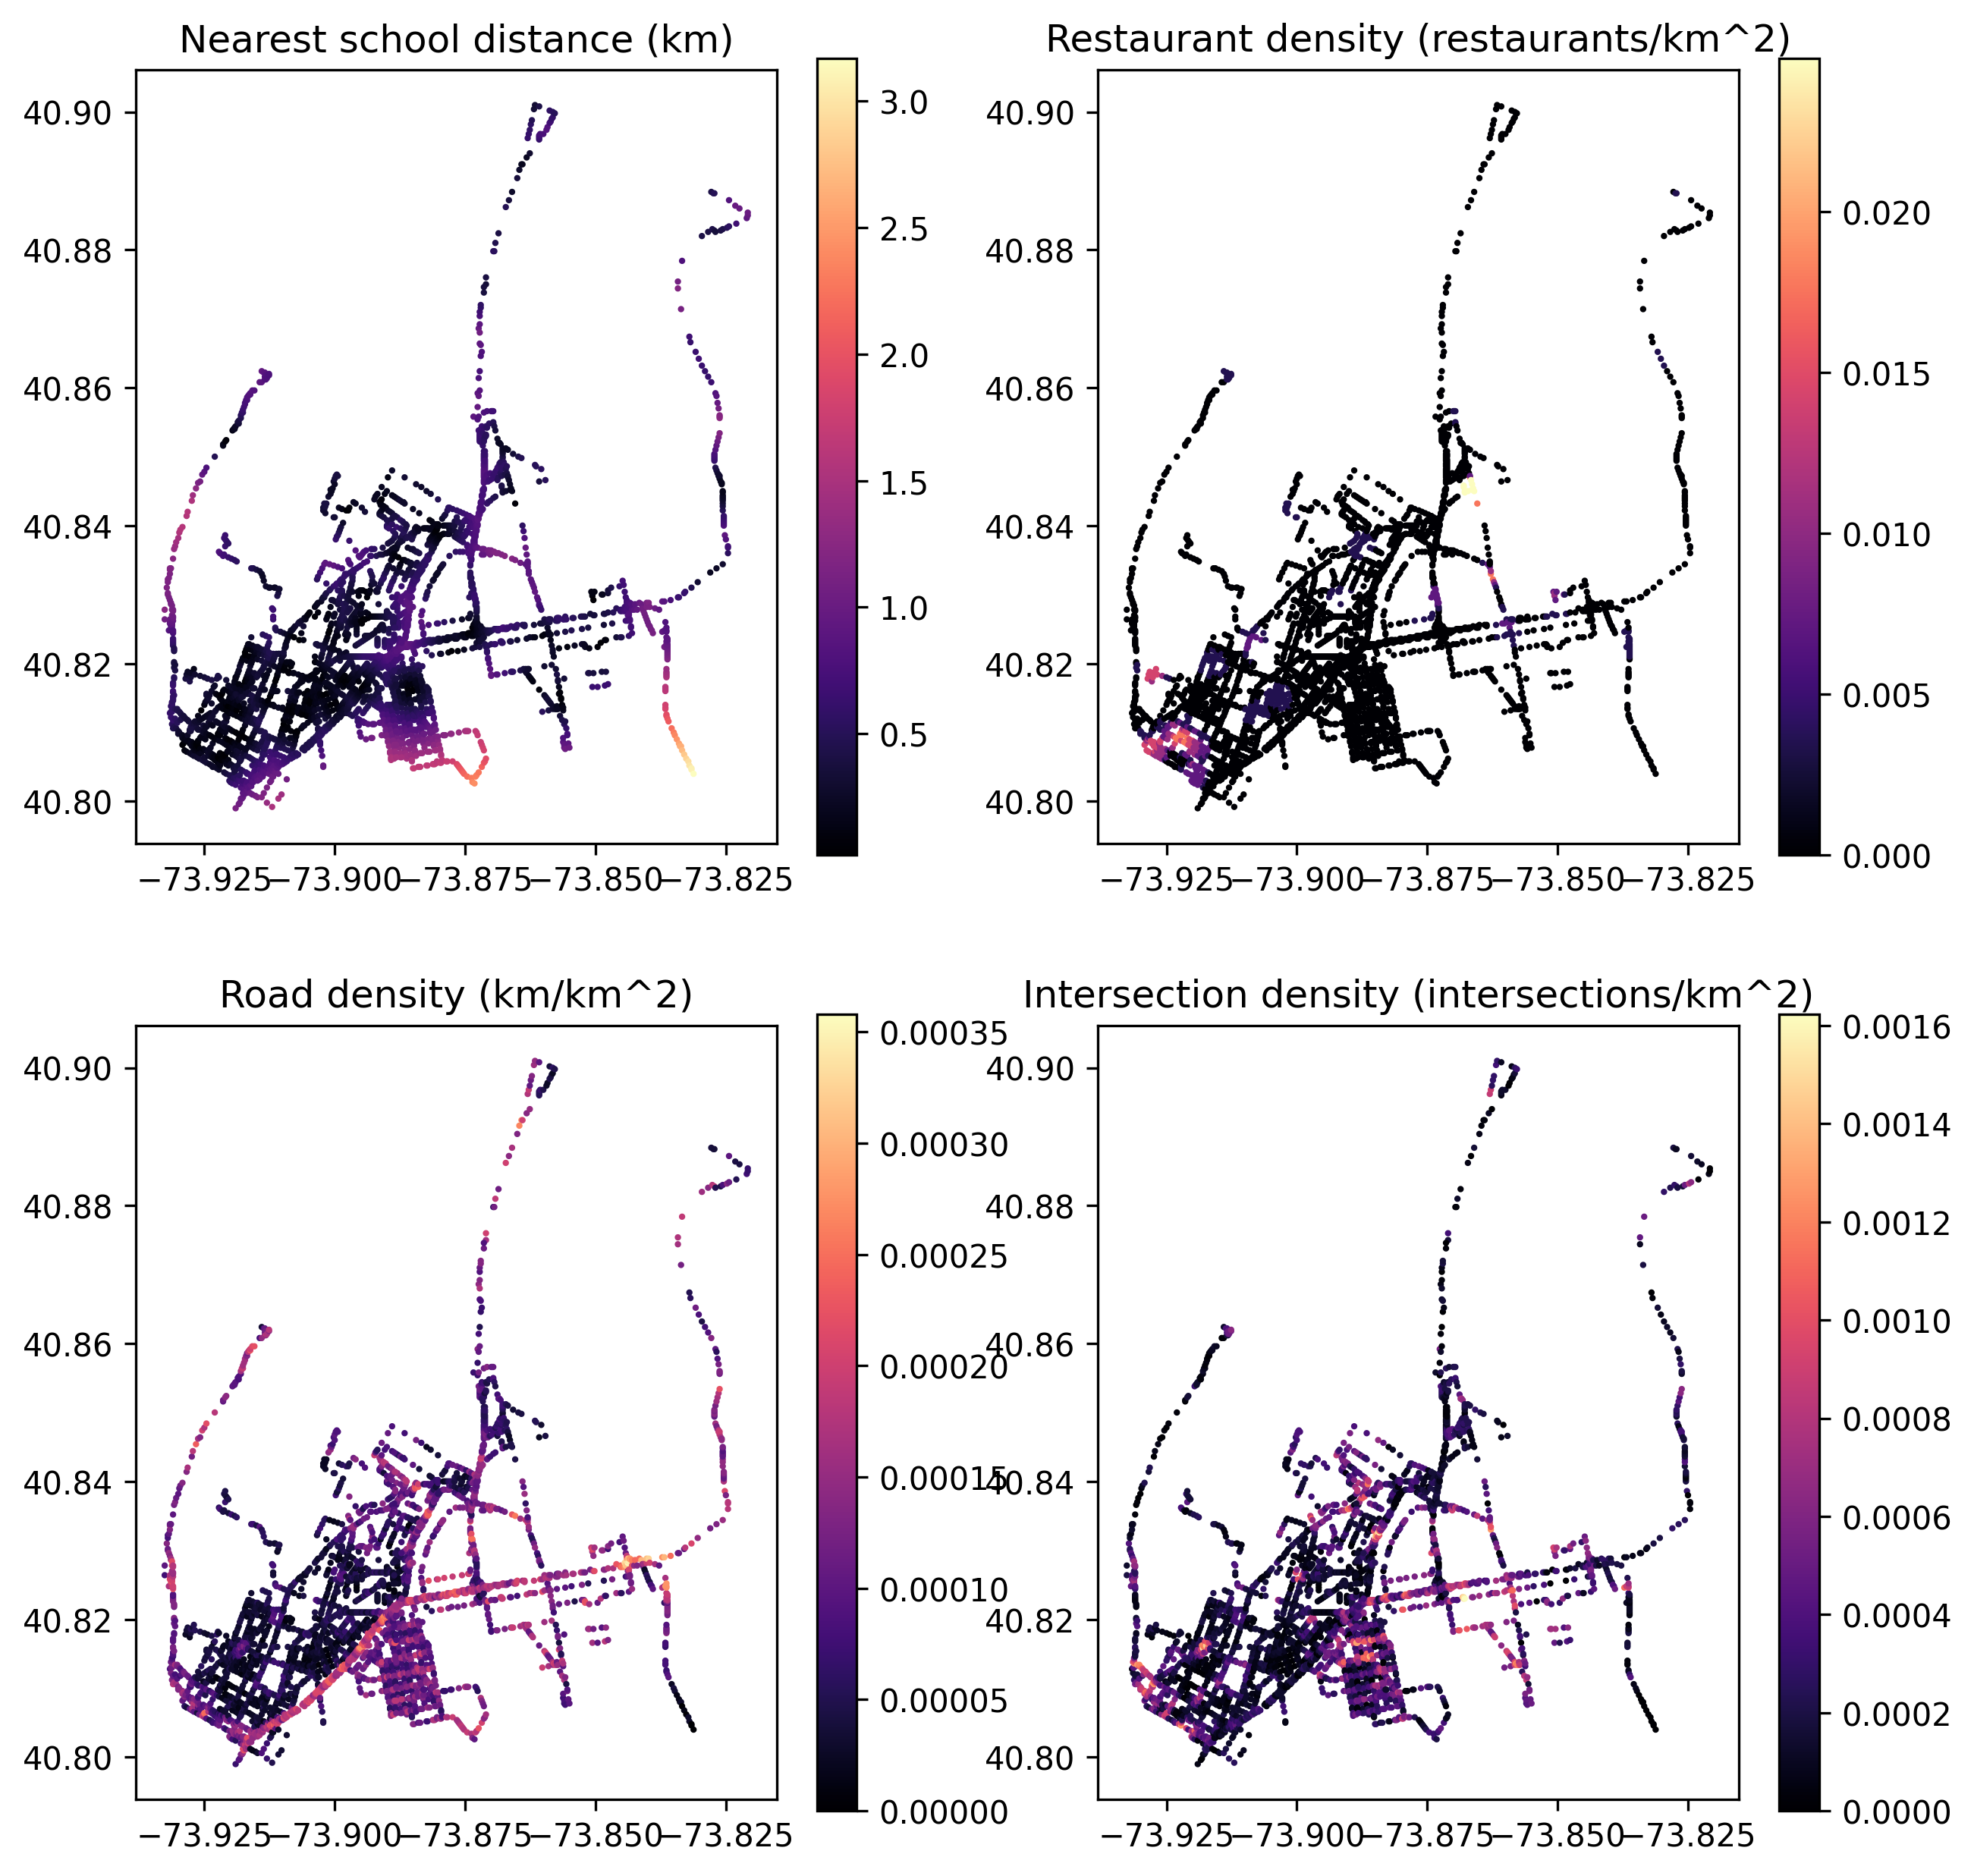

In [15]:
fig, ax = plt.subplots(2, 2, figsize=[10, 10])
pts.plot("nearest_school_distance", legend=True, ax=ax[0, 0], markersize=1, cmap="magma")
pts.plot("restaurant_density", legend=True, ax=ax[0, 1], markersize=1, cmap="magma")
pts.plot("road_density", legend=True, ax=ax[1, 0], markersize=1, cmap="magma")
pts.plot("intersection_density", legend=True, ax=ax[1, 1], markersize=1, cmap="magma")
ax[0, 0].set_title("Nearest school distance (km)")
ax[0, 1].set_title("Restaurant density (restaurants/km^2)")
ax[1, 0].set_title("Road density (km/km^2)")
ax[1, 1].set_title("Intersection density (intersections/km^2)")

# save the figure
fig.savefig("notebooks/figs/point_features.png")

# save also every axis
for i, a in enumerate(ax.flat):
    a.get_figure().savefig(f"notebooks/diagfigs/point_features_{i}.png")

Extract labels (fine resolution PM2.5)

In [16]:
pts_feats = pts.copy()
y = pts_feats[["pm25", "geometry"]]
pts_feats = pts_feats.drop(columns=["road", "tract", "lon", "lat", "pm25"])

In [17]:
print("Final point features")
display(pts_feats)

Final point features


time_of_day                    geometry  restaurant_density  \
8199    11.183333  POINT (-73.88820 40.82660)            0.000000   
8201    13.200000  POINT (-73.88820 40.82880)            0.000000   
8207    14.033333  POINT (-73.88820 40.83300)            0.000000   
8214    14.966667  POINT (-73.88820 40.83660)            0.003537   
8218    14.766667  POINT (-73.88820 40.83980)            0.000000   
...           ...                         ...                 ...   
8183     9.716667  POINT (-73.88820 40.81780)            0.000000   
8186    12.183333  POINT (-73.88820 40.82040)            0.000000   
8187    10.750000  POINT (-73.88820 40.82060)            0.000000   
8189    15.650000  POINT (-73.88820 40.82140)            0.000000   
8191    12.433333  POINT (-73.88820 40.82180)            0.000000   

      nearest_school_distance  road_density  intersection_density  
8199                 0.558591      0.000050              0.000095  
8201                 0.673612      0.000043              0.000223  
8207                 0.383996      0.000071              0.000191  
8214                 0.172295      0.000074              0.000159  
8218                 0.625830      0.000135              0.000828  
...                       ...           ...                   ...  
8183                 0.386097      0.000071              0.000318  
8186                 0.680238      0.000093              0.000382  
8187                 0.706377      0.000102              0.000382  
8189                 0.813179      0.000168              0.000446  
8191                 0.854374      0.000159              0.000286  

[3939 rows x 6 columns]

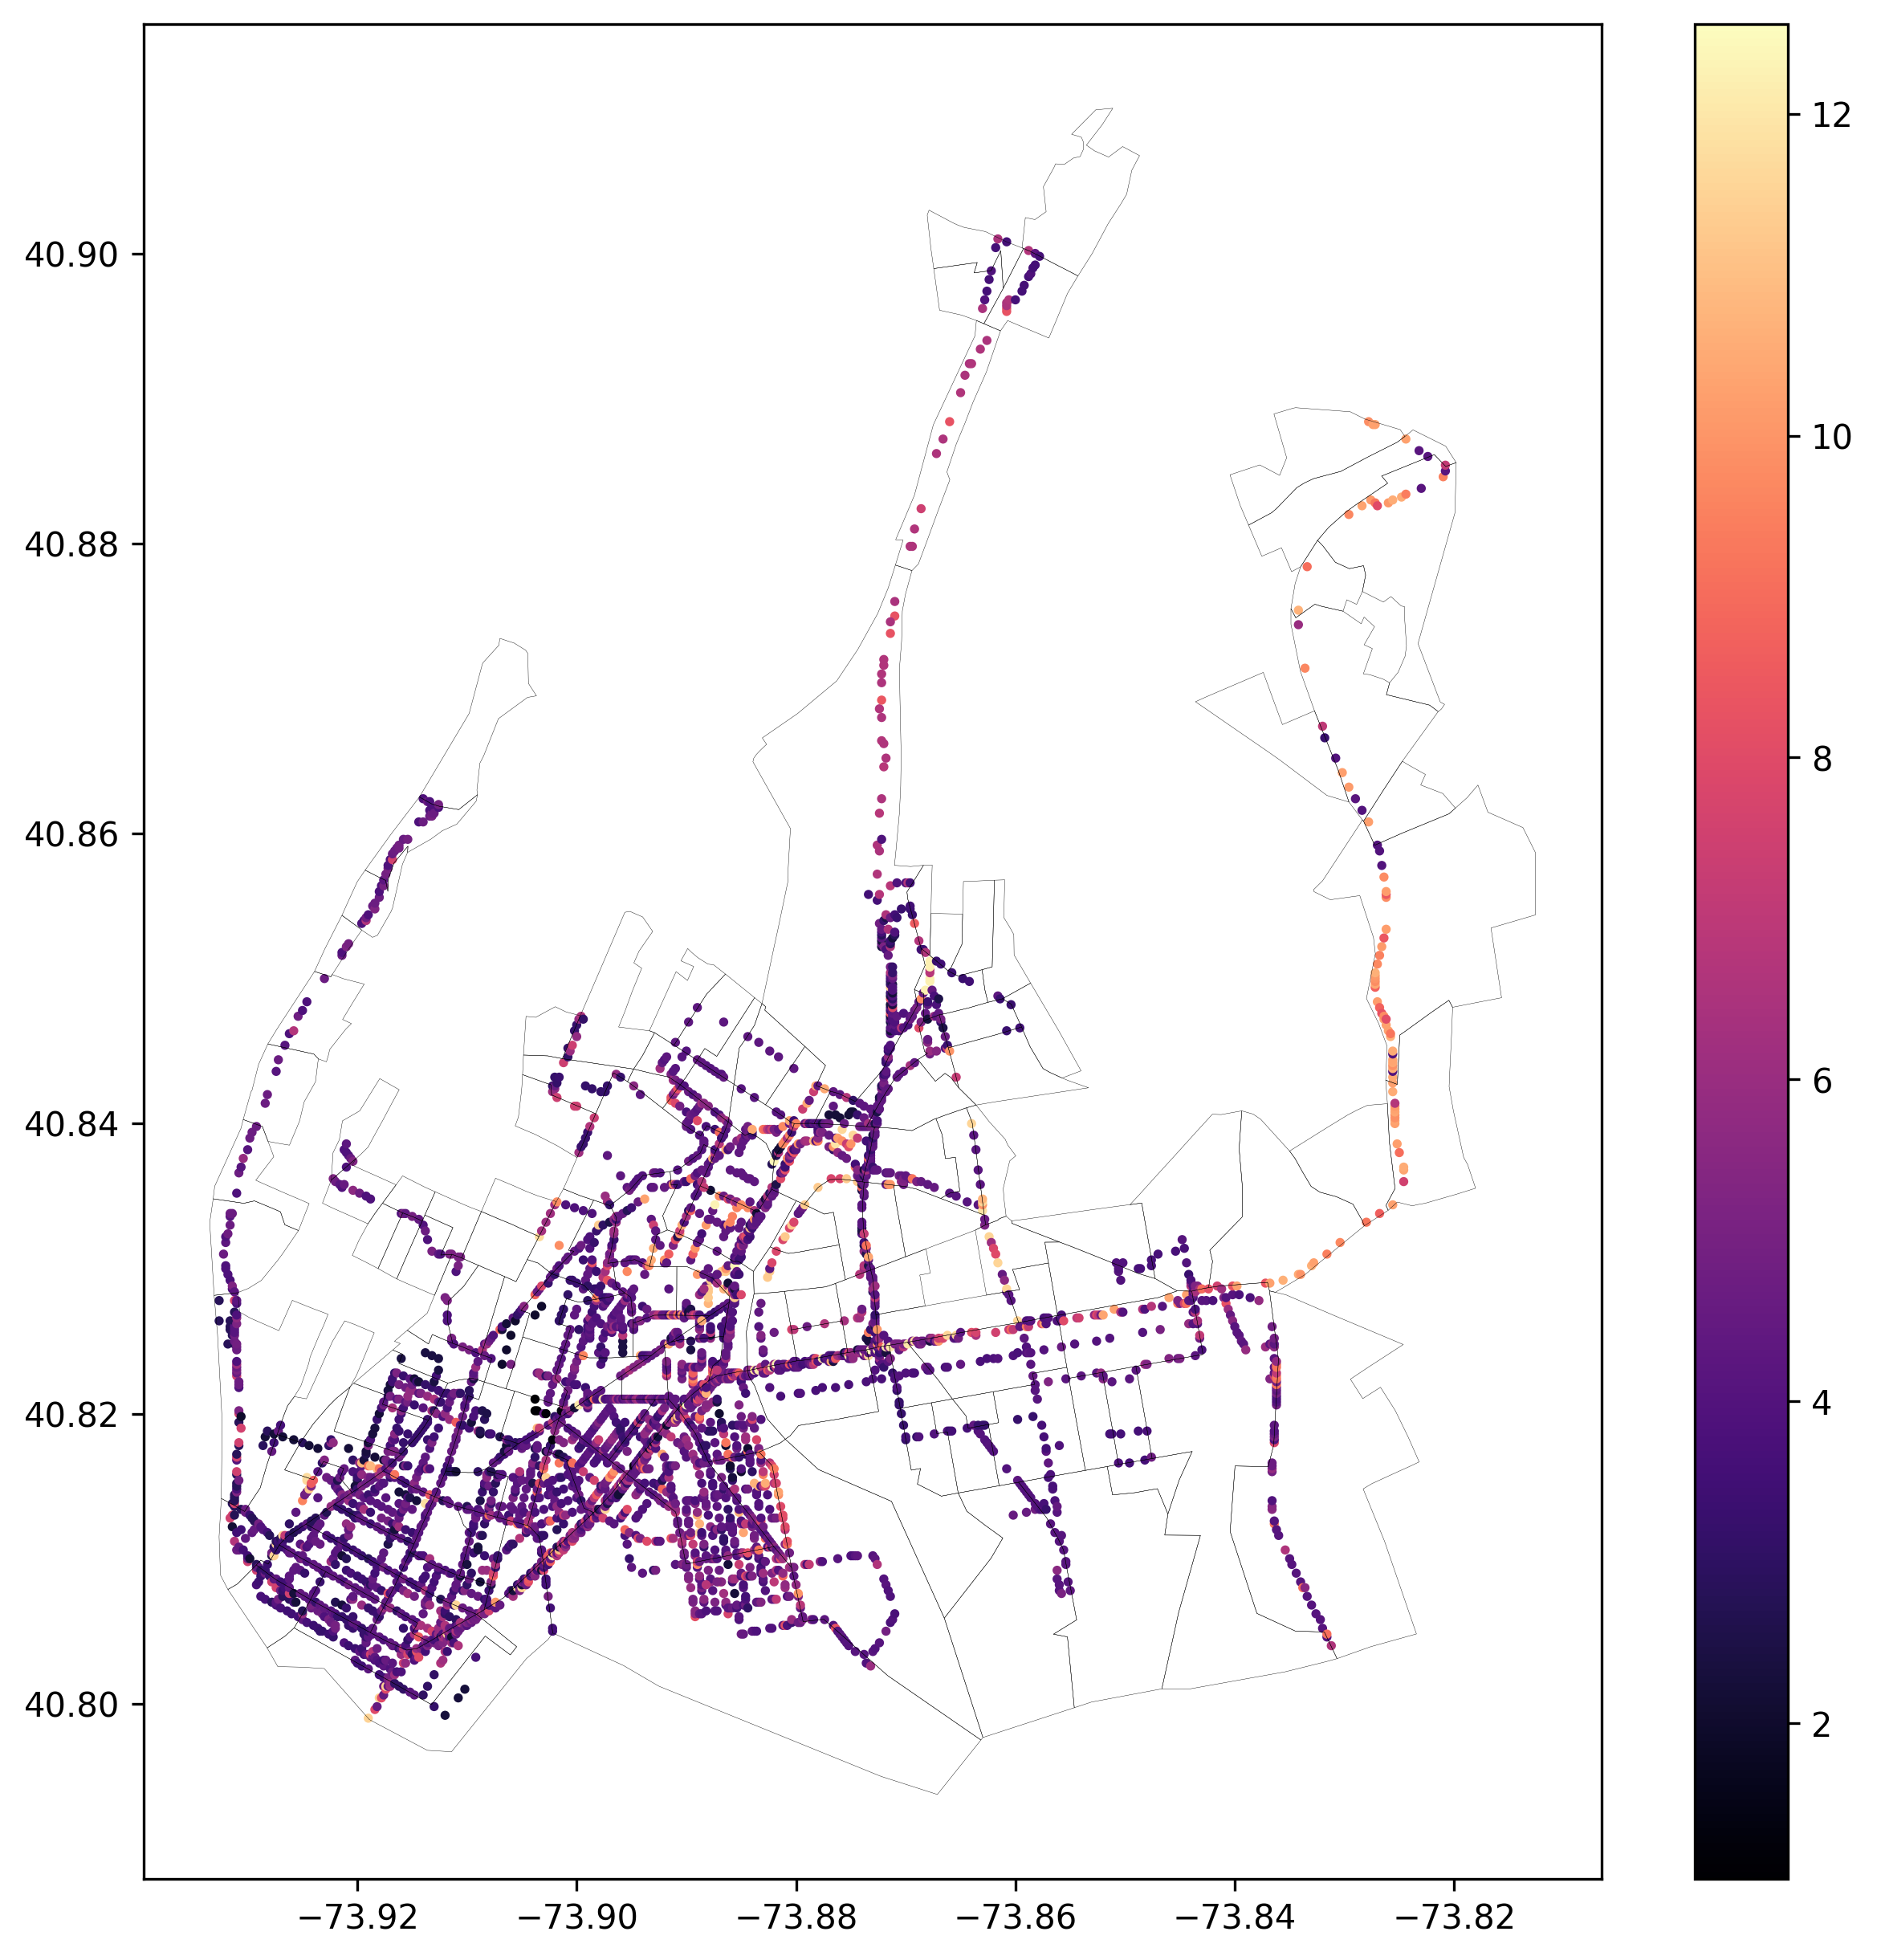

In [18]:
fig, ax = plt.subplots(figsize=[10, 10])
pts.plot("pm25", legend=True, markersize=3, cmap="magma", ax=ax)
tracts.boundary.plot(color="black", lw=0.1, ax=ax)
plt.savefig("notebooks/figs/pm25_points.png")

### Road traffic-level (rank 1)

Obtain and visualize features from the AADT (Annual Average Daily Traffic) dataset.

In [19]:
# load aadt data, crs=2263, used in NYC commonly, convert to WGS84
aadt = gpd.read_file("data/aadt_and_truckpct/features.shp", crs="EPSG:2263")
aadt = aadt.to_crs(wgs84)

# coerce the following vars to numeric, handling comma-separated numbers and % signs
print("Columns:", ", ".join(aadt.columns))
c = ["AADT_2021", "AAWDT_2021", "PCT_2021"]
for col in c:
    aadt[col] = pd.to_numeric(aadt[col].str.replace(",", "").str.replace("%", ""))

# crop to bounds of Bronx
aadt = aadt.cx[
    roads.total_bounds[0] : roads.total_bounds[2],
    roads.total_bounds[1] : roads.total_bounds[3],
]

Columns: id, name, desc, county, route, fromMile, toMile, fc, latitude, longitude, AADT_2023, AAWDT_2023, PCT_2023, AADT_2022, AAWDT_2022, PCT_2022, AADT_2021, AAWDT_2021, PCT_2021, AADT_2020, AAWDT_2020, PCT_2020, AADT_2019, AAWDT_2019, PCT_2019, AADT_2018, AAWDT_2018, PCT_2018, AADT_2017, AAWDT_2017, PCT_2017, AADT_2016, AAWDT_2016, PCT_2016, geometry


Since we want the traffic at a road level. Use KNN regression to assign the traffic to the roads.

  0%|          | 0/550 [00:00<?, ?it/s]

Final road features


AADT_2021   PCT_2021  \
1705   4409.377599   8.088868   
1073  22705.226497   5.040125   
1666  35394.234403   6.727934   
2360  35394.234403   6.727934   
592   36070.724997   6.877638   
...            ...        ...   
984    5927.020699   5.760361   
1995   9803.546701   6.721701   
999    5287.347331   5.519859   
2744  10616.300021   9.240825   
1697  25463.536133  10.178980   

                                               geometry  
1705  LINESTRING (-73.93258 40.82553, -73.93258 40.8...  
1073  LINESTRING (-73.93151 40.83084, -73.93194 40.8...  
1666  LINESTRING (-73.87801 40.90597, -73.87811 40.9...  
2360  LINESTRING (-73.91148 40.80494, -73.91233 40.8...  
592   LINESTRING (-73.87819 40.90598, -73.87829 40.9...  
...                                                 ...  
984   LINESTRING (-73.81151 40.81946, -73.81287 40.8...  
1995  LINESTRING (-73.82525 40.83694, -73.82461 40.8...  
999   LINESTRING (-73.82354 40.88565, -73.82417 40.8...  
2744  LINESTRING (-73.82259 40.88594, -73.82278 40.8...  
1697  LINESTRING (-73.83057 40.88336, -73.82964 40.8...  

[550 rows x 3 columns]

Text(0.5, 1.0, 'Road AADT 2021 in Bronx, NY')

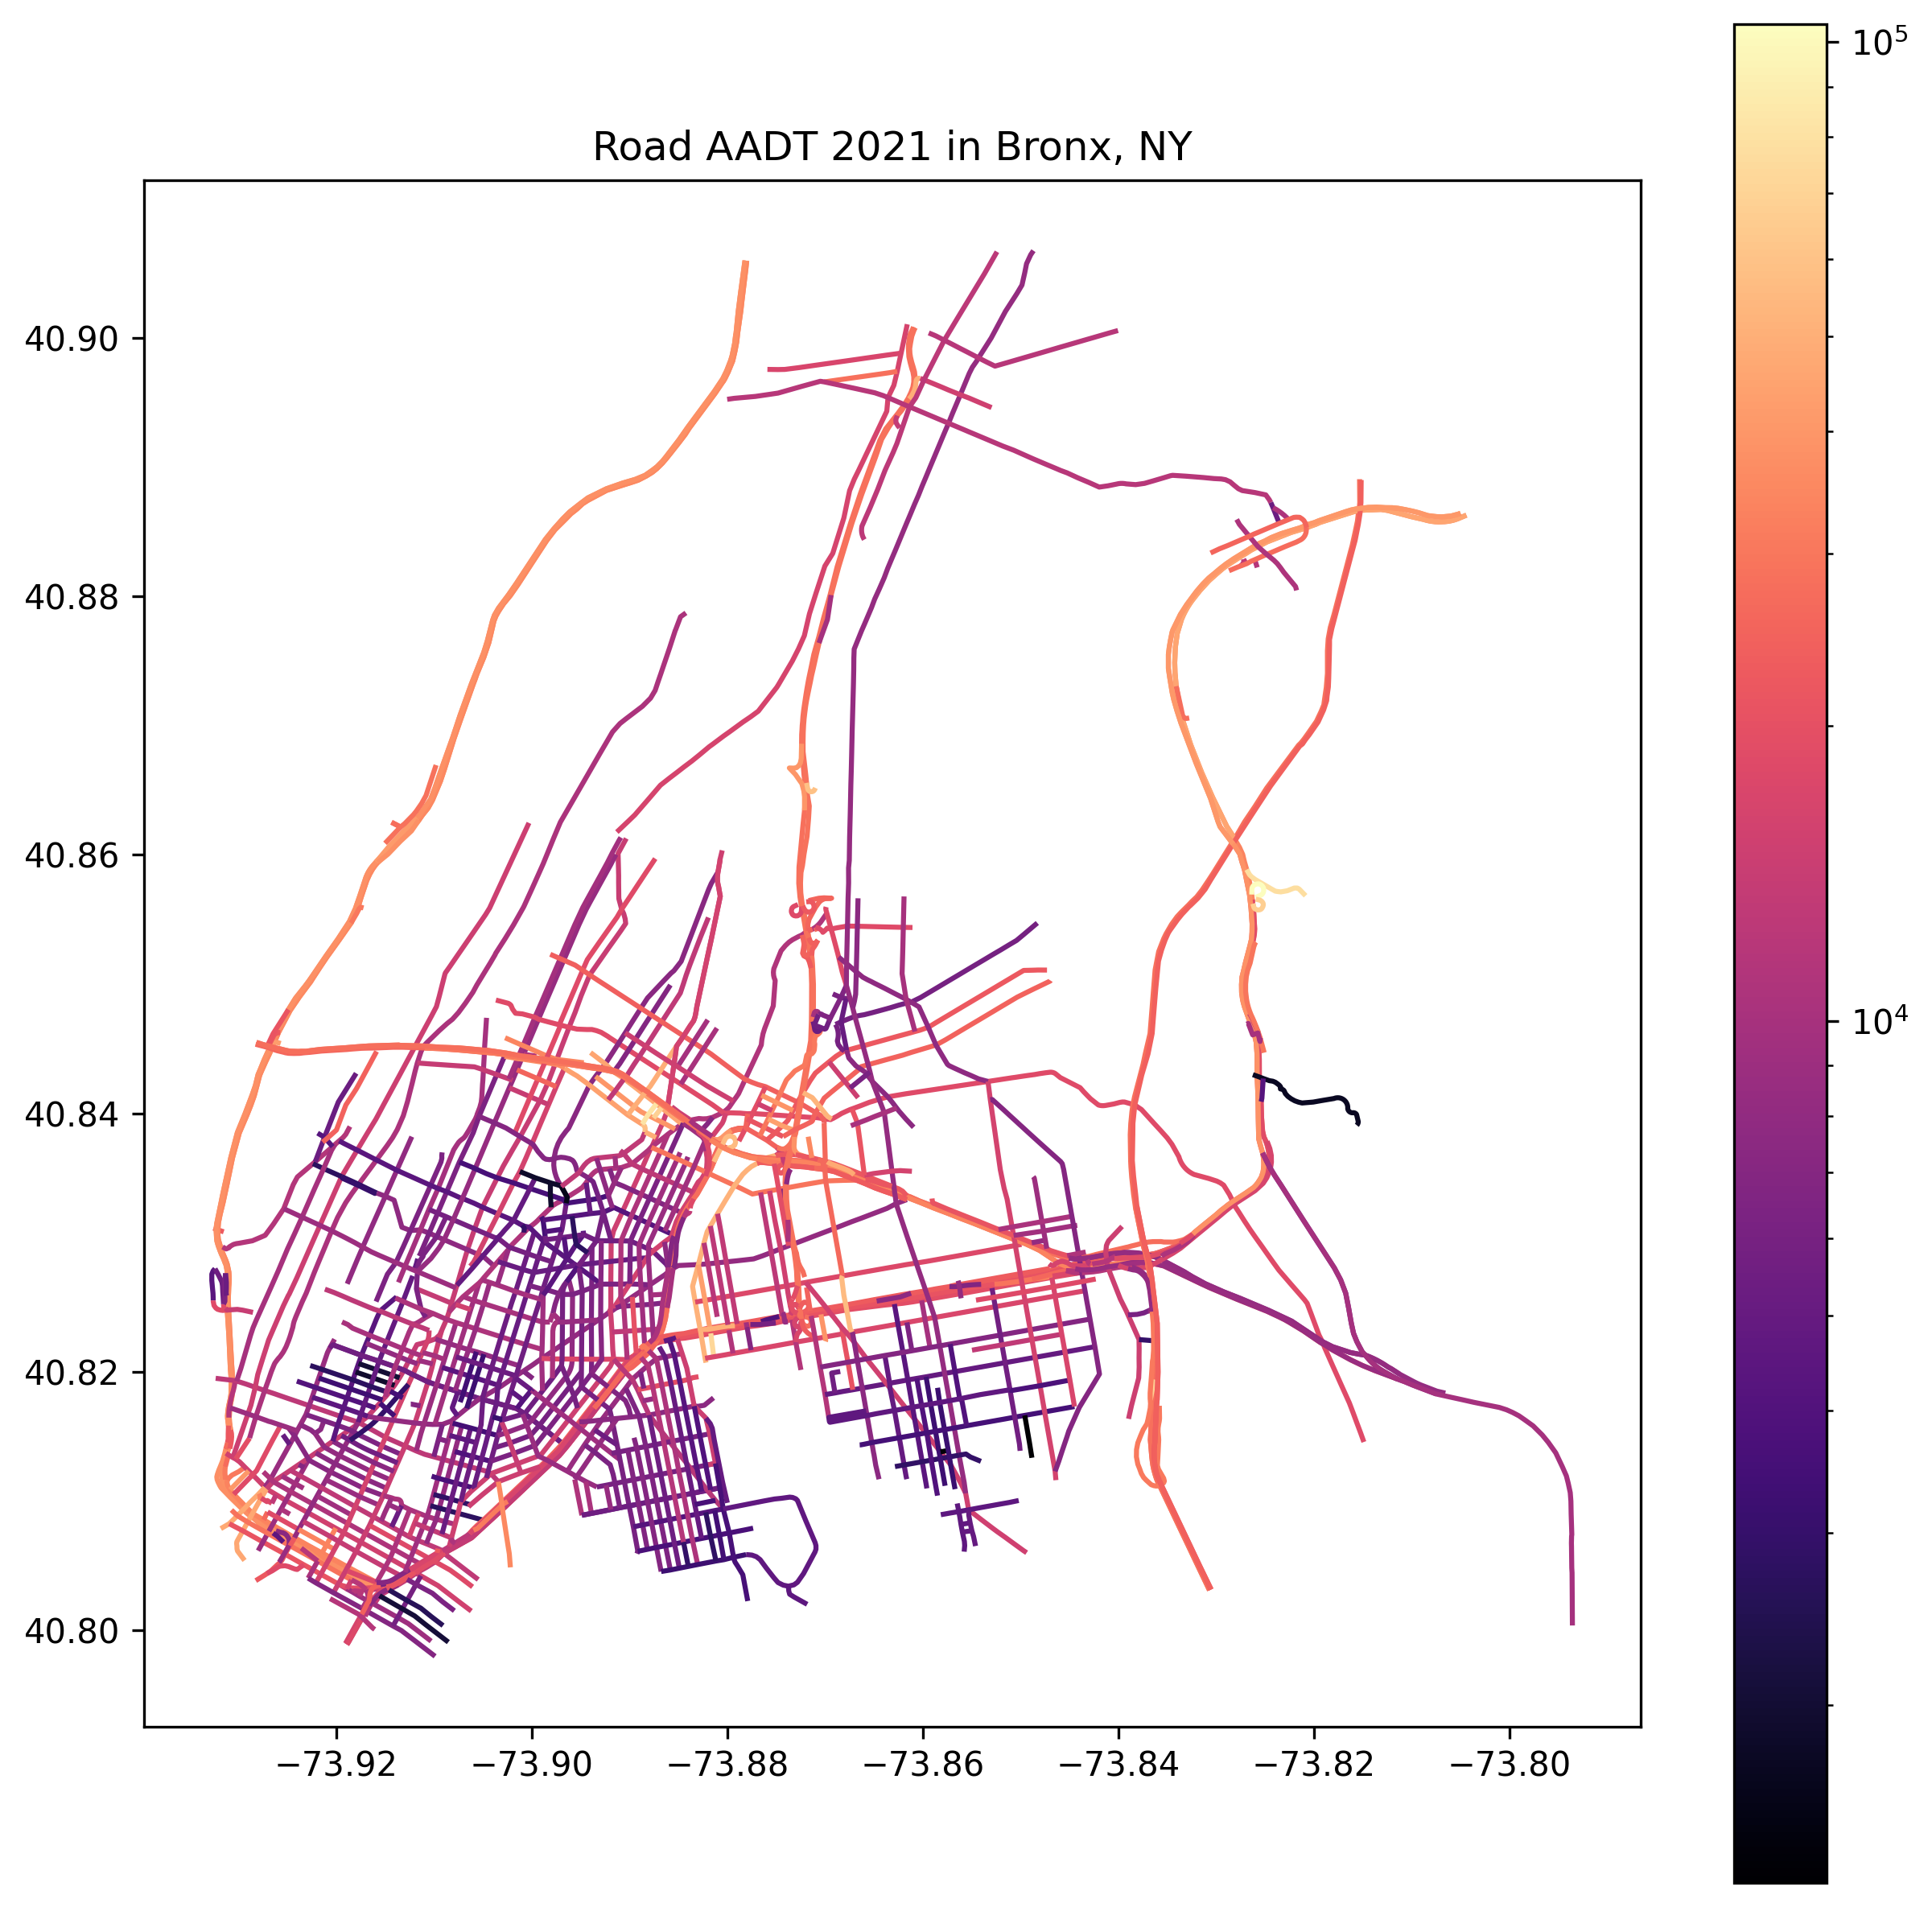

In [20]:
# make a weighted knn predictor
from sklearn.neighbors import KNeighborsRegressor

c = ["AADT_2021", "PCT_2021"]
Y = aadt[c]  # pandas
X = aadt[["longitude", "latitude"]]
knn = KNeighborsRegressor(n_neighbors=3, weights="distance")

# # remove NaNs
nan_ix = Y.isna().any(axis=1)
X = X.loc[~nan_ix]
Y = Y.loc[~nan_ix]

knn.fit(X, Y)

# predict AADT for each road, evaluate on all the points of the line and average
road_feats = []
for ix, row in tqdm(roads.iterrows(), total=roads.shape[0]):
    road = row.geometry
    lon, lat = road.xy
    Xtest = pd.DataFrame({"longitude": lon, "latitude": lat})
    preds = knn.predict(Xtest)
    road_feats.append(preds.mean(axis=0))
road_feats = np.array(road_feats)
road_feats = gpd.GeoDataFrame(
    road_feats, columns=Y.columns, geometry=roads.geometry.values, index=roads.index
)
print("Final road features")
display(road_feats)

norm = matplotlib.colors.LogNorm(
    vmin=road_feats.AADT_2021.min(), vmax=road_feats.AADT_2021.max()
)
fig, ax = plt.subplots(figsize=[10, 10])
road_feats.plot(column="AADT_2021", cmap="magma", norm=norm, legend=True, ax=ax)
# cx.add_basemap(ax, crs=roads.crs, source=cx.providers.USGS.USTopo)
plt.savefig("notebooks/figs/road_feats.png")
plt.title("Road AADT 2021 in Bronx, NY")

### Census tracts from Coarse aggregated PM 2.5 & NYC zoning (rank 2)

We will now load the coarsen PM 2.5 dataset. The dataset is already in the repository under `data/tract_level_pm25.parquet`. These data is from Wei et al. (The Lancet Planetary Health; 2023). For convenience, we have pre-aggregated the values at the Census tract level from it's native 1km resolution (which is more lower than the 30m high-resolution targets here).

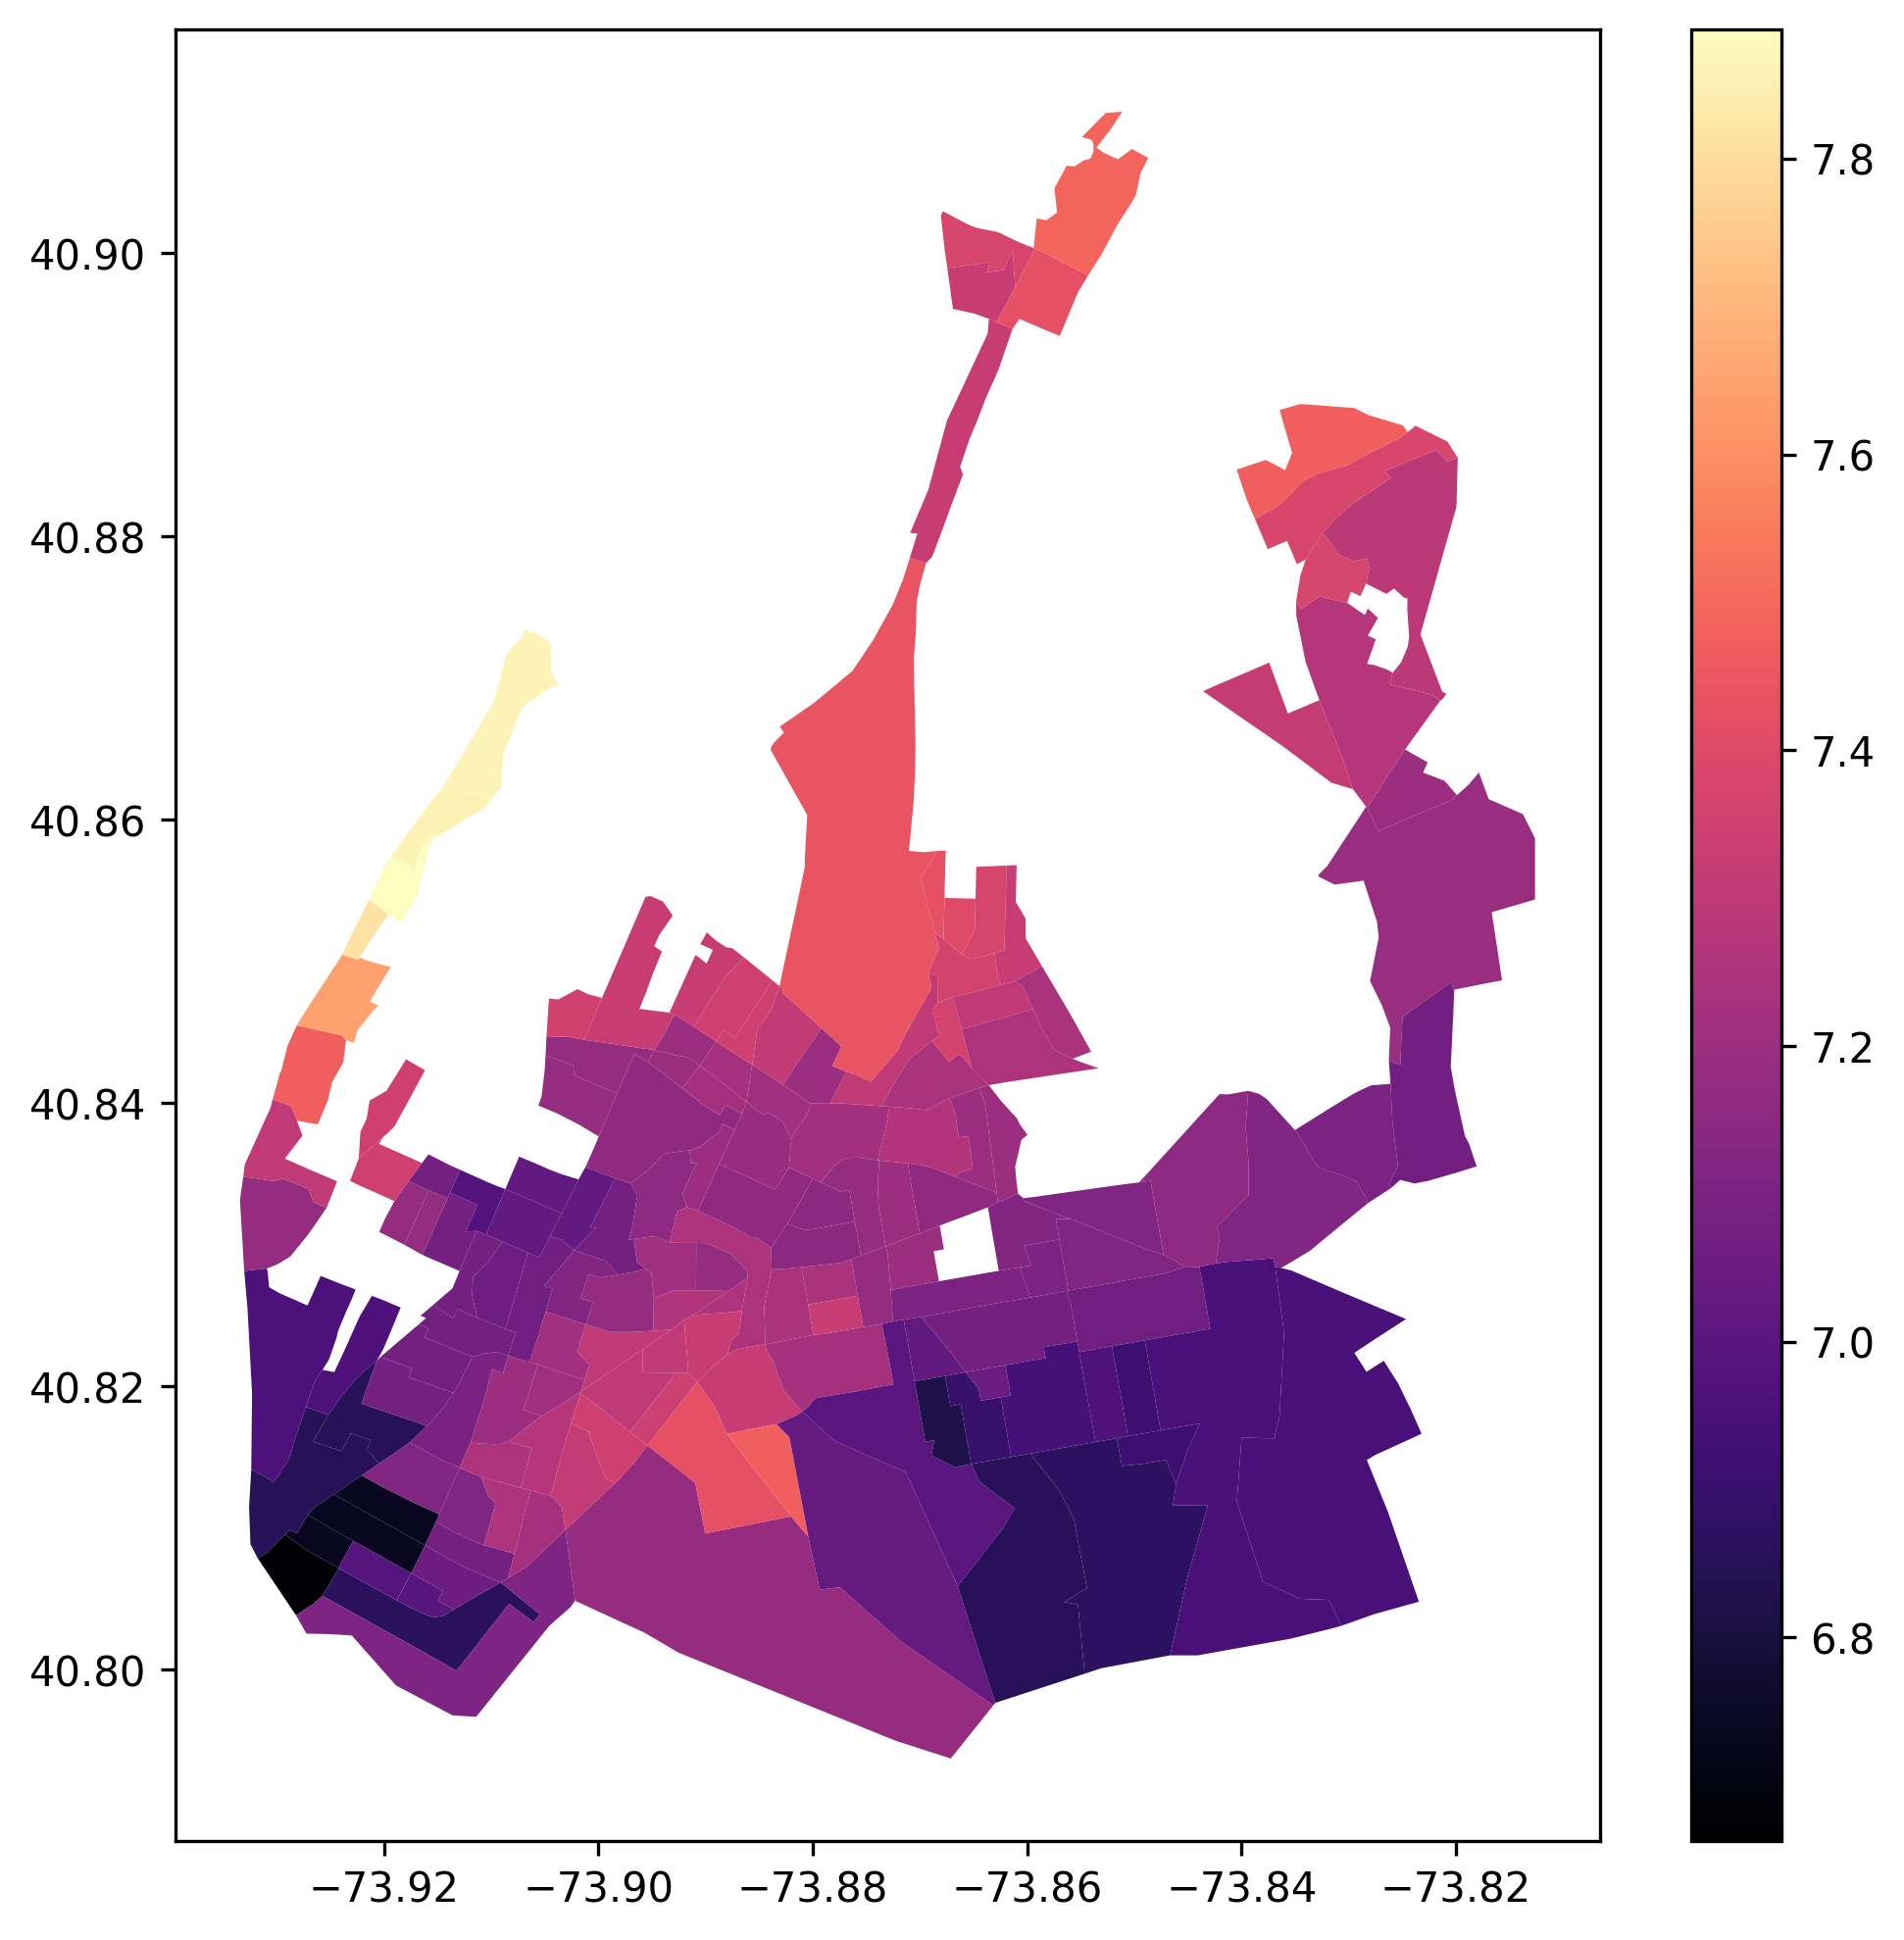

In [21]:
# cat pm25 to tracts
# these data already has only the months of the study period
monthly_tract_pm = pd.read_parquet(
    "data/coarse_pm25_bronx_tract_wei_et_al_2023.parquet"
)
monthly_tract_pm = monthly_tract_pm[monthly_tract_pm.month.isin([9, 10, 11, 12])]
tract_pm = (
    monthly_tract_pm.reset_index()
    .rename(columns={"bronx": "GEOID"})
    .groupby("GEOID")  # rename and aggregate by month at the same time
    .agg(coarse_pm25=pd.NamedAgg(column="PM2.5", aggfunc="mean"))
    .reset_index()
    .set_index("GEOID")
)

# left join on GEOID columns
tracts["coarse_pm25_predictor"] = tract_pm.coarse_pm25.loc[tracts.GEOID.values].values
# tracts = tracts.merge(tract_pm, how="left", on="GEOID
tracts.plot(column="coarse_pm25_predictor", legend=True, cmap="magma")

# visualize pm 25
os.makedirs("notebooks/figs", exist_ok=True)
plt.savefig("notebooks/figs/bronx_pm25.png")

We now add features from the PLUTO 

In [22]:
# Primary Land Use Tax Lot Output (PLUTO)
# crs=2263, used in NYC commonly, convert to WGS84
df = pd.read_csv("data/nyc_pluto_24v1_1_csv/pluto_24v1_1.csv", low_memory=False)
df.rename(columns={"block": "tax_block"}, inplace=True)
df.rename(columns={"bctcb2020": "block"}, inplace=True)
df.rename(columns={"bct2020": "tract"}, inplace=True)
print("Columns:", ", ".join(df.columns))

# remove NaNs from bctcb2020zw
df = df[df.borough == "BX"]

# process as string and keep only last 4 digits
df = df[df.block.notna() & df.landuse.notna()]
df["block"] = df["block"].astype(int).astype(str).str[-4:].astype(int)
df["tract"] = df["tract"].astype(int).astype(str).str[-6:].astype(int)
display(df)

# transform assesstot to millions of dollar
df["assesstot"] = df["assesstot"] / 1e6

# categorical variables to be made one-hot and summed
# cat_cols = ["bldgclass", "landuse"]
cat_cols = ["landuse"]

area_feats = [
    "bldgarea",
    "comarea",
    "resarea",
    "officearea",
    "retailarea",
    "factryarea",
]

# map land use
mapping = [
    ([1], "one_two_family"),
    ([2, 3], "multi_family_elevator"),
    ([4, 5], "mixed_residential_commercial"),
    # ([5], "commercial_office"),
    ([6], "industrial_manufacturing"),
    ([7], "transportation_utility"),
    ([8], "public_facilities_institutions"),
    ([9], "open_space_outdoor_recreation"),
    ([10, 11], "parking/vacant"),
]
df["landuse"] = df["landuse"].astype(int)
for classes, new_class in mapping:
    df.loc[df.landuse.isin(classes), "landuse"] = new_class

# features to be averaged by LotArea
av_feats = ["assesstot", "lotfront", "lotdepth"]

orig_cols = df.columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True, prefix=cat_cols)
new_cat_cols = list(df.columns.difference(orig_cols))
print("New dummy columns:", ", ".join(new_cat_cols))

# do groupby, start with sum
dfagg = df.groupby(["tract"])[area_feats + new_cat_cols + ["lotarea"]].sum()

# now compute an weighted average of av_feats by LotArea
def nan_weighted_mean(x, wts):
    isna = np.isnan(x) | np.isnan(wts)
    x = x[~isna]
    wts = wts[~isna] + 1e-6
    return np.nanmean(x * wts) / np.nansum(wts)


for col in av_feats + new_cat_cols:
    dfagg[col] = df.groupby("tract")[[col, "lotarea"]].apply(
        lambda x: nan_weighted_mean(x[col].values, x.lotarea.values)
    )


# transform the count and area features to density and pcts respectively by dividing by lotarea
for col in area_feats:
    dfagg[col] = dfagg[col] / dfagg["lotarea"]

# transform lot area from squared feed to squared kilometers
dfagg["lotarea"] = dfagg["lotarea"] * 0.000000092903

# remove nans
dfagg = dfagg.dropna()
print("Columns:", ", ".join(dfagg.columns))

# find the elements in dfagg.index that are also in tracts.TRACTCE
indexes = dfagg.index[dfagg.index.isin(tracts.index)]
dfagg = dfagg.loc[indexes]
tracts = tracts.loc[indexes]

# convert to gpd
tract_feats = gpd.GeoDataFrame(
    dfagg, geometry=tracts.geometry.loc[dfagg.index], crs=tracts.crs, index=dfagg.index
)
tract_feats["coarse_pm25"] = tracts.coarse_pm25_predictor.loc[
    tract_feats.index.values
].values
tract_feats = tract_feats.reset_index()
tract_feats = tract_feats.rename({"tract": "id"}, axis=1)

Columns: borough, tax_block, lot, cd, tract, block, ct2010, cb2010, schooldist, council, zipcode, firecomp, policeprct, healthcenterdistrict, healtharea, sanitboro, sanitdistrict, sanitsub, address, zonedist1, zonedist2, zonedist3, zonedist4, overlay1, overlay2, spdist1, spdist2, spdist3, ltdheight, splitzone, bldgclass, landuse, easements, ownertype, ownername, lotarea, bldgarea, comarea, resarea, officearea, retailarea, garagearea, strgearea, factryarea, otherarea, areasource, numbldgs, numfloors, unitsres, unitstotal, lotfront, lotdepth, bldgfront, bldgdepth, ext, proxcode, irrlotcode, lottype, bsmtcode, assessland, assesstot, exempttot, yearbuilt, yearalter1, yearalter2, histdist, landmark, builtfar, residfar, commfar, facilfar, borocode, bbl, condono, tract2010, xcoord, ycoord, zonemap, zmcode, sanborn, taxmap, edesignum, appbbl, appdate, plutomapid, firm07_flag, pfirm15_flag, version, dcpedited, latitude, longitude, notes


borough  tax_block   lot     cd  tract  block  ct2010  cb2010  \
10          BX       4260   136  211.0  23000   2001  230.00  2002.0   
133         BX          0  8900  208.0  33500   1002  335.00  1002.0   
154         BX       3365    22  212.0  44901   2003  449.01  2003.0   
171         BX       5643   625  210.0  51601      1  516.00     2.0   
179         BX       3831    75  209.0   9600   1001   96.00  1001.0   
...        ...        ...   ...    ...    ...    ...     ...     ...   
858532      BX       2288    12  201.0   4100   2000   41.00  2000.0   
858536      BX       5306   126  210.0  19400   1013  194.00  1019.0   
858537      BX       2364    25  201.0   7100   2001   71.00  2001.0   
858539      BX       5626   402  210.0  51601      1  516.00     2.0   
858553      BX       5626    99  210.0  51601      1  516.00     2.0   

        schooldist  council  ...  appbbl appdate  plutomapid  firm07_flag  \
10            11.0     13.0  ...     NaN     NaN           1          NaN   
133           10.0     11.0  ...     NaN     NaN           3          NaN   
154           11.0     11.0  ...     NaN     NaN           1          NaN   
171            NaN     13.0  ...     NaN     NaN           4          1.0   
179            8.0     18.0  ...     NaN     NaN           1          NaN   
...            ...      ...  ...     ...     ...         ...          ...   
858532         7.0      8.0  ...     NaN     NaN           1          NaN   
858536         8.0     13.0  ...     NaN     NaN           1          NaN   
858537         7.0     17.0  ...     NaN     NaN           1          NaN   
858539         NaN     13.0  ...     NaN     NaN           4          1.0   
858553         NaN     13.0  ...     NaN     NaN           1          1.0   

        pfirm15_flag  version  dcpedited   latitude  longitude notes  
10               NaN   24v1.1        NaN  40.849720 -73.865346   NaN  
133              NaN   24v1.1        NaN  40.899813 -73.905920   NaN  
154              NaN   24v1.1        NaN  40.896744 -73.874337   NaN  
171              1.0   24v1.1          t  40.847503 -73.781340   NaN  
179              NaN   24v1.1        NaN  40.833427 -73.847072   NaN  
...              ...      ...        ...        ...        ...   ...  
858532           NaN   24v1.1        NaN  40.812440 -73.919624   NaN  
858536           NaN   24v1.1        NaN  40.831629 -73.831408   NaN  
858537           NaN   24v1.1          t  40.821044 -73.911933   NaN  
858539           1.0   24v1.1        NaN  40.842879 -73.789527   NaN  
858553           1.0   24v1.1        NaN  40.840549 -73.788089   NaN  

[89061 rows x 92 columns]

/var/folders/h3/2f91vbwj7r506n1w06610njh0000gn/T/ipykernel_85273/1227653917.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'one_two_family' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.landuse.isin(classes), "landuse"] = new_class


New dummy columns: landuse_mixed_residential_commercial, landuse_multi_family_elevator, landuse_one_two_family, landuse_open_space_outdoor_recreation, landuse_parking/vacant, landuse_public_facilities_institutions, landuse_transportation_utility
Columns: bldgarea, comarea, resarea, officearea, retailarea, factryarea, landuse_mixed_residential_commercial, landuse_multi_family_elevator, landuse_one_two_family, landuse_open_space_outdoor_recreation, landuse_parking/vacant, landuse_public_facilities_institutions, landuse_transportation_utility, lotarea, assesstot, lotfront, lotdepth


In [23]:
# final set of tract features
print("Final tract features")
display(tract_feats)

Final tract features


id  bldgarea   comarea   resarea  officearea  retailarea  factryarea  \
0      200  0.266297  0.014688  0.230103    0.000223    0.004151    0.002596   
1      400  0.264036  0.014356  0.235935    0.000527    0.003073    0.000000   
2     1600  1.069532  0.438426  0.601089    0.081915    0.018124    0.000000   
3     1901  3.812645  0.911818  2.854734    0.216406    0.230910    0.056124   
4     1902  1.425532  0.997668  0.346947    0.081079    0.031895    0.537697   
..     ...       ...       ...       ...         ...         ...         ...   
146  46203  0.426216  0.339647  0.078076    0.067065    0.042594    0.009948   
147  46205  0.659798  0.659798  0.000000    0.197960    0.245396    0.001415   
148  46207  1.902246  1.902246  0.000000    0.000000    0.848956    0.000000   
149  46209  0.655938  0.287899  0.348172    0.018474    0.050552    0.048227   
150  48401  0.620076  0.222253  0.355940    0.007100    0.023833    0.076555   

     landuse_mixed_residential_commercial  landuse_multi_family_elevator  \
0                                0.000006                       0.000048   
1                                0.000011                       0.000258   
2                                0.000272                       0.000323   
3                                0.006307                       0.001442   
4                                0.000348                       0.000138   
..                                    ...                            ...   
146                              0.001818                       0.000086   
147                              0.014224                       0.000000   
148                              1.000000                       0.000000   
149                              0.000467                       0.001019   
150                              0.000119                       0.000161   

     landuse_one_two_family  landuse_open_space_outdoor_recreation  \
0                  0.000329                               0.000009   
1                  0.000240                               0.000458   
2                  0.000456                               0.000478   
3                  0.000000                               0.000000   
4                  0.000164                               0.000184   
..                      ...                                    ...   
146                0.000186                               0.000415   
147                0.000000                               0.000230   
148                0.000000                               0.000000   
149                0.000314                               0.000000   
150                0.000524                               0.000004   

     landuse_parking/vacant  landuse_public_facilities_institutions  \
0                  0.000664                                0.000015   
1                  0.000255                                0.000015   
2                  0.000398                                0.000718   
3                  0.001818                                0.000550   
4                  0.000204                                0.000065   
..                      ...                                     ...   
146                0.005501                                0.001363   
147                0.002421                                0.010903   
148                0.000000                                0.000000   
149                0.000468                                0.000105   
150                0.000158                                0.000091   

     landuse_transportation_utility   lotarea  assesstot    lotfront  \
0                          0.000000  0.583213   0.000214    0.339109   
1                          0.000002  0.849728   0.008111    0.410327   
2                          0.000000  0.333306   0.032768    0.888606   
3                          0.000204  0.069696   0.181801    2.123340   
4                          0.000541  0.226121   0.004670    0.469884   
..      

Text(0.5, 1.0, 'Retailarea in Bronx, NY')

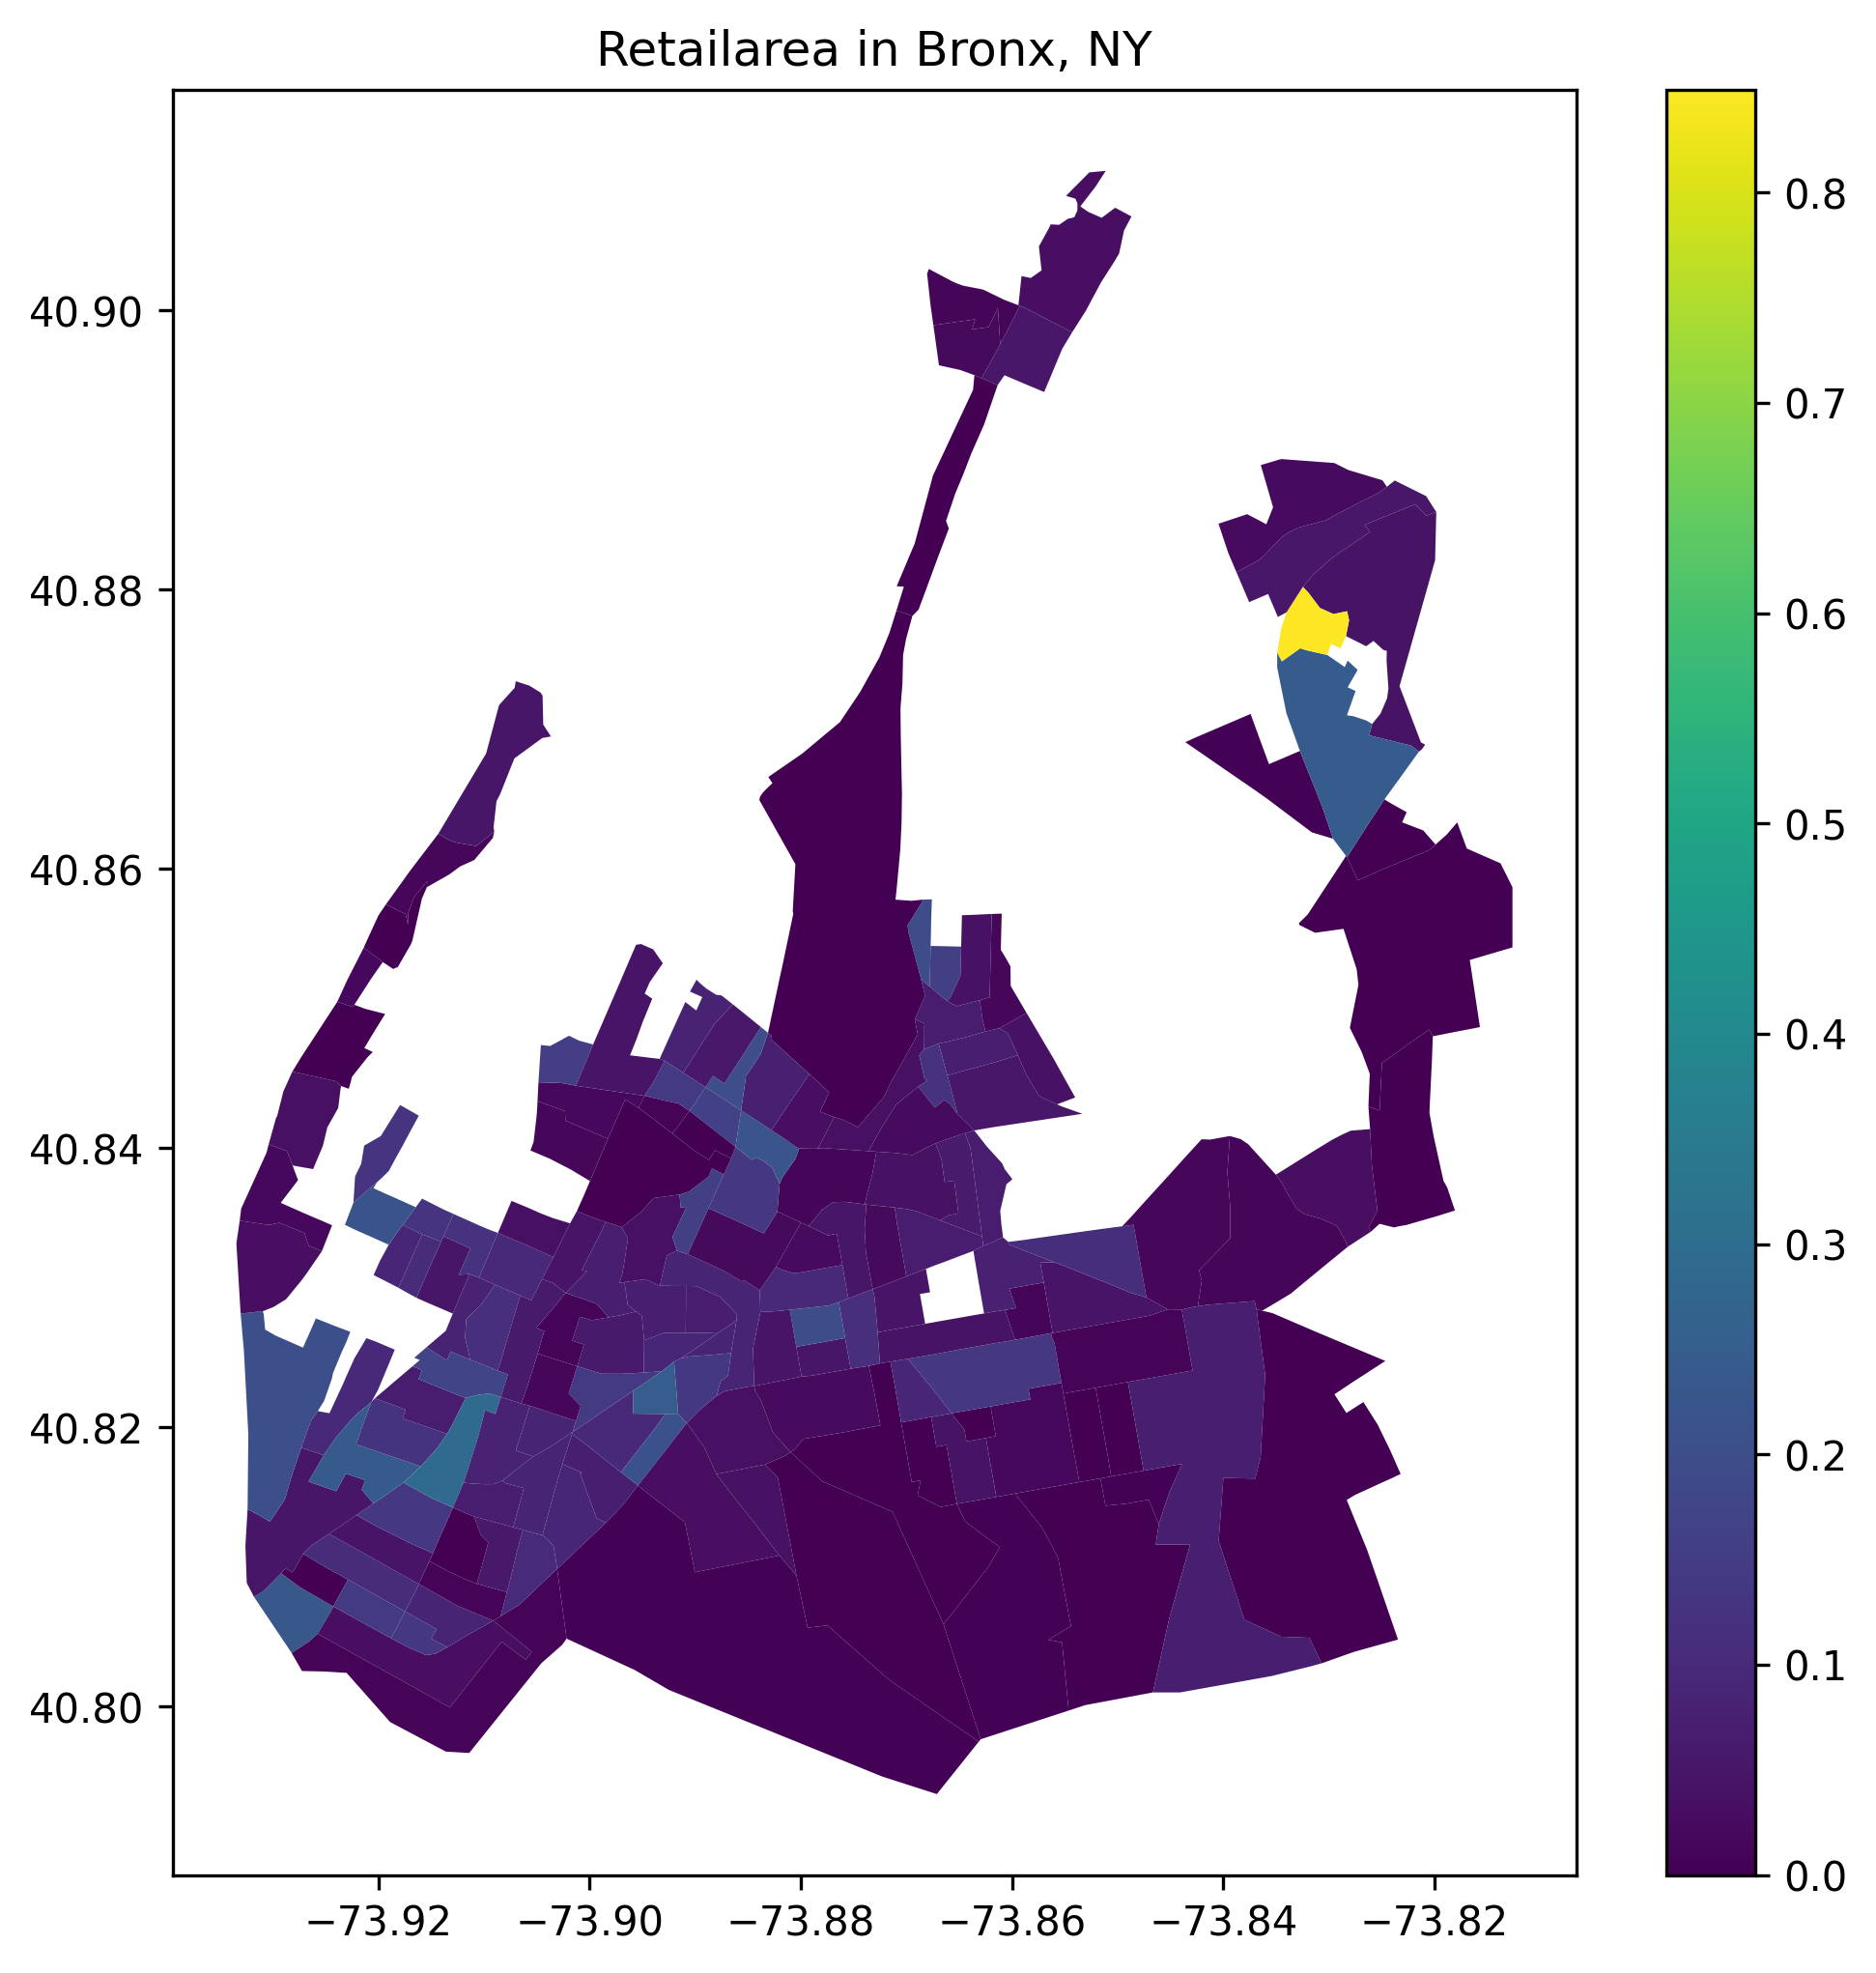

In [24]:
# visualize an exmple feature
tract_feats.plot("retailarea", legend=True)
plt.title("Retailarea in Bronx, NY")

## 4. Create adjacency graphs

#### Rank 0 Adjacency: KNN

In [26]:
# generate knn graph, record knn graph as list of edges
knn = NearestNeighbors(n_neighbors=3, metric="euclidean")
lon = pts_feats.geometry.x.values
lat = pts_feats.geometry.y.values
coords = np.stack([lon, lat], axis=1)
coords = pd.DataFrame(coords, columns=["lon", "lat"], index=pts.index)
knn.fit(coords)
distances, indices = knn.kneighbors(coords)
adj_pts = []
for ix, row in tqdm(enumerate(indices), total=indices.shape[0]):
    for i in row:
        if ix != i:
            adj_pts.append([int(ix), int(i)])

print("Number of points:", pts_feats.shape[0])
print("Number of edges of KNN(4) graph on points:", len(adj_pts))

  0%|          | 0/3939 [00:00<?, ?it/s]

Number of points: 3939
Number of edges of KNN(4) graph on points: 7878


#### Rank 1/2 Adjacency: Spatial Contiguity

In [27]:
sjoin = gpd.sjoin(roads_buff, roads_buff, predicate="intersects", how="inner")
adj_roads = []
for ix, row in tqdm(sjoin.iterrows(), total=sjoin.shape[0]):
    if ix != row.index_right:
        adj_roads.append([int(ix), int(row.index_right)])
print("Number of roads:", road_feats.shape[0])
print("Number of edges of adjacency graph on roads:", len(adj_roads))

  0%|          | 0/5306 [00:00<?, ?it/s]

Number of roads: 550
Number of edges of adjacency graph on roads: 4756


In [30]:
sjoin = gpd.sjoin(tract_buff, tract_buff, predicate="intersects", how="inner")
adj_tracts = []
for ix, row in tqdm(sjoin.iterrows(), total=sjoin.shape[0]):
    if ix != row.index_right:
        adj_tracts.append([int(ix), int(row.index_right)])
print("Number of tracts:", tract_feats.shape[0])
print("Number of edges of adjacency graph on tracts:", len(adj_tracts))

  0%|          | 0/923 [00:00<?, ?it/s]

Number of tracts: 151
Number of edges of adjacency graph on tracts: 772


## 5. Export

In [31]:
adj_1_0 = np.zeros((2, len(edges_pts_road)), dtype=int)
adj_2_1 = np.zeros((2, len(edges_road_tract)), dtype=int)
adj_0_0 = np.zeros((2, len(adj_pts)), dtype=int)
adj_1_1 = np.zeros((2, len(adj_roads)), dtype=int)
adj_2_2 = np.zeros((2, len(adj_tracts)), dtype=int)

for j in range(adj_0_0.shape[1]):
    adj_0_0[0, j] = adj_pts[j][0]
    adj_0_0[1, j] = adj_pts[j][1]

for j in range(adj_1_1.shape[1]):
    adj_1_1[0, j] = ixmap_roads[adj_roads[j][0]]
    adj_1_1[1, j] = ixmap_roads[adj_roads[j][1]]

for j in range(adj_2_2.shape[1]):
    adj_2_2[0, j] = ixmap_tracts[adj_tracts[j][0]]
    adj_2_2[1, j] = ixmap_tracts[adj_tracts[j][1]]

for j in range(adj_1_0.shape[1]):
    adj_1_0[1, j] = edges_pts_road[j][0]
    adj_1_0[0, j] = edges_pts_road[j][1]

for j in range(adj_2_1.shape[1]):
    adj_2_1[1, j] = edges_road_tract[j][0]
    adj_2_1[0, j] = edges_road_tract[j][1]


data = {
    "x_0": pts_feats.drop(columns=["geometry"]).values.tolist(),
    "x_1": road_feats.drop(columns=["geometry"]).values.tolist(),
    "x_2": tract_feats.drop(columns=["geometry"]).values.tolist(),
    "pos": pts_feats.geometry.apply(lambda x: [x.x, x.y]).values.tolist(),
    "cell_0": cell_0,
    "cell_1": cell_1,
    "cell_2": cell_2,
    "adj_1_0": adj_1_0.tolist(),
    "adj_2_1": adj_2_1.tolist(),
    "adj_0_0": adj_0_0.tolist(),
    "adj_1_1": adj_1_1.tolist(),
    "adj_2_2": adj_2_2.tolist(),
    "adj_0_1": adj_1_0[::-1].tolist(),  # [::-1] flips the array
    "adj_1_2": adj_2_1[::-1].tolist(),
    "y": y[["pm25"]].values.tolist(),
}

data["num_features_dict"] = {
    0: len(data["x_0"][0]),
    1: len(data["x_1"][0]),
    2: len(data["x_2"][0]),
}

with open("data/raw/spatial_cc.json", "w") as f:
    json.dump(data, f)